In [2]:
#Note: runs on sq env

In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import matplotlib
from matplotlib.transforms import Bbox
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.manifold
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.stats
import scipy.cluster
import glob
import ast
import itertools
import matplotlib.colors
import scanpy.external as sce
from matplotlib import cm
import anndata
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 1,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 1,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial',
                            'patch.edgecolor' : 'black'})

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, fontsize=15, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

In [2]:
sq.__version__


'1.1.2'

In [3]:
# error settings to avoid crowding the notebook
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [4]:
'Ignore warnings'
import warnings
warnings.filterwarnings('ignore')

Load definitions

In [5]:
flatten = lambda t: [item for sublist in t for item in sublist]

def get_key(val, my_dict): 
    for key, value in my_dict.items(): 
         if val == value: 
            return key 
  
    return "key doesn't exist"

def get_colors_dict():
    colors_to_rois_dict = dict(
    memimmsm = 'muscle and submucosa',
    base_all = 'epithelium and muscle and submucosa',
    eplp = 'epithelium',
    eplpmm = "epithelium and mucosae",
    ext = "externa",
    mm_mix = "externa and interna",
    interna = "interna",
    interna_mm = "mucosae and interna",
    apex = "crypt apex and mucosa",
    mid = "crypt mid",
    base_mid = "crypt base",
    base_mm1 = "crypt mid and apex",
    eplpmmsm = "epithelium and mucosae and submucosa",
    pp = "peyer's patch",
    muc = 'mucosa',
    mucpel = 'mucosa and pellet',
    pel = 'pellet',
    )
    return colors_to_rois_dict

def get_areas_legends():
    areas_legends = dict(    
            memimmsm = (222/255,101/255,167/255,1),
            base_all = (164/255,180/255,217/255,1),
            eplp = (199/255,183/255,217/255,1),
            empty = (205/255,201/255,215/255,1),
            eplpmm =  (227/255,111/255,171/255,1),
            ext = (106/255,82/255,162/255,1),
            mm_mix =  (107/255,97/255,171/255,1),
            interna =  (187/255,91/255,163/255,1),
            interna_mm = (211/255,134/255,185/255,1),
            apex = (239/255,228/255,240/255,1),
            mid = (220/255,202/255,226/255,1),
            base_mid = (153/255,112/255,196/255,1),
            base_mm1 = (133/255,86/255,155/255,1),
            eplpmmsm =  (209/255,151/255,184/255,1),
            pp = (78/255,97/255,172/255,1),
            pel = (205/255,200/255,214/255,1),
            mucpel = (150/255,150/255,150/255,1)
    )
    return areas_legends

def ranges_sizes(dot_min, dot_max,smallest_dot,largest_dot):
    diff = dot_max - dot_min
    if 0.3 < diff <= 0.6:
        step = 0.1
    elif diff <= 0.3:
        step = 0.05
    else:
        step = 0.2
    # a descending range that is afterwards inverted is used
    # to guarantee that dot_max is in the legend.
    size_range = np.arange(dot_max, dot_min, step * -1)[::-1]
    if dot_min != 0 or dot_max != 1:
        dot_range = dot_max - dot_min
        size_values = (size_range - dot_min) / dot_range
    else:
        size_values = size_range
    size_exponent = 2
    size = size_values ** size_exponent
    size = size * (largest_dot - smallest_dot) + smallest_dot
    
    return size

def get_raster_whole_tissue(variable_of_interest, age):
    raster_path = "/Users/sanjavickovic/Library/Mobile Documents/com~apple~CloudDocs/Desktop/data/host-microbiome/data/rasters"
    raster_img = "raster_whole_tissue_"+variable_of_interest+"_"+age+".png"
    im = Image.open(os.path.join(raster_path,raster_img))
    im = im.convert('RGBA')
    # make np array 
    data = np.array(im)   # "data" is a height x width x 4 np array
    red, green, blue, alpha = data.T # Temporarily unpack the bands for readability


    areas = dict(    
    memimmsm = (red == 222) & (green==101) & (blue ==167 ) & (alpha == 255), 
    base_all = (red == 164) & (green == 180) & (blue == 221) & (alpha == 255),
    eplp = ((red >=199 ) & (red <= 200)) & ((green >=182) & (green <= 183)) & ((blue >=217) & (blue <= 218)) & (alpha == 255),
    #empty = (red == 205) & (green == 200) & (blue == 214) & (alpha == 255),
    eplpmm =  (red == 226) & (green==111) & (blue == 171) & (alpha == 255), 
    ext = (red == 107) & ((green >=81) & (green <= 83)) & ((blue >=162) & (blue <= 163)) & (alpha == 255),
    #mm_mix =  ((red >=186 ) & (red <= 187)).any() & ((green >=98) & (green <= 99)).any() & ((blue >=171) & (blue <= 172)).any() & (alpha == 255),
    mm_mix = ((red >=107 ) & (red <= 109)) & ((green >=98) & (green <= 100)) & ((blue >=171) & (blue <= 172)) & (alpha == 255),
    interna =  ((red >=186 ) & (red <= 187)) & ((green >=92) & (green <= 96)) & ((blue >=163) & (blue <= 165)) & (alpha == 255), 
    interna_mm = ((red >=210 ) & (red <= 211)) & ((green >=134) & (green <= 135)) & ((blue >=183) & (blue <= 185)) & (alpha == 255),
    apex = ((red >=236 ) & (red <= 237)) & ((green >=224) & (green <= 227)) & ((blue >=239) & (blue <= 240)) & (alpha == 255),
    mid = ((red >=220 ) & (red <= 222)) & ((green >=201) & (green <= 203)) & ((blue >=227) & (blue <= 228)) & (alpha == 255),
    base_mid = (red == 153) & (green == 112) & (blue == 196) & (alpha == 255),
    base_mm1 = (red == 133) & (green == 86) & (blue == 155) & (alpha == 255),
    #base_mm2 = (red == 179) & (green==155) & (blue == 202) & (alpha == 255), 
    eplpmmsm =  ((red >=209 ) & (red <= 212)) & ((green >=151) & (green <= 152)) & (blue == 184) & (alpha == 255),
    pp = (red == 78) & (green == 97) & (blue == 172) & (alpha == 255),
    #eplppp = (red == 25) & (green==28) & (blue == 75) & (alpha == 255), #ok
    #mmpp = (red == 95) & (green==88) & (blue == 114) & (alpha == 255), #ok
    #mmintpp = (red == 57) & (green==87) & (blue == 166) & (alpha == 255), #ok
    pel = (red == 205) & (green == 200) & (blue == 214) & (alpha == 255),
    mucpel = (red == 150) & (green == 150) & (blue == 150) & (alpha == 255),
    )
    
    return red, green, blue, alpha, data, areas


def get_raster(variable_of_interest, age):
    raster_path = "/Users/sanjavickovic/Library/Mobile Documents/com~apple~CloudDocs/Desktop/data/host-microbiome/data/rasters"
    raster_img = "raster_"+variable_of_interest+"_"+age+".png"
    im = Image.open(os.path.join(raster_path,raster_img))
    im = im.convert('RGBA')
    # make np array 
    data = np.array(im)   # "data" is a height x width x 4 np array
    red, green, blue, alpha = data.T # Temporarily unpack the bands for readability
    
    areas = dict(    
    memimmsm = (red == 222) & (green==101) & (blue ==167 ) & (alpha == 255), 
    base_all = (red == 164) & (green == 180) & (blue == 221) & (alpha == 255),
    eplp = ((red >=199 ) & (red <= 200)) & ((green >=182) & (green <= 183)) & ((blue >=217) & (blue <= 218)) & (alpha == 255),
    empty = (red == 205) & (green == 200) & (blue == 214) & (alpha == 255),
    eplpmm =  (red == 226) & (green==111) & (blue == 171) & (alpha == 255), 
    ext = (red == 107) & ((green >=81) & (green <= 83)) & ((blue >=162) & (blue <= 163)) & (alpha == 255),
    #mm_mix =  ((red >=186 ) & (red <= 187)).any() & ((green >=98) & (green <= 99)).any() & ((blue >=171) & (blue <= 172)).any() & (alpha == 255),
    mm_mix = ((red >=107 ) & (red <= 109)) & ((green >=98) & (green <= 100)) & ((blue >=171) & (blue <= 172)) & (alpha == 255),
    interna =  ((red >=186 ) & (red <= 187)) & ((green >=92) & (green <= 96)) & ((blue >=163) & (blue <= 165)) & (alpha == 255), 
    interna_mm = ((red >=210 ) & (red <= 211)) & ((green >=134) & (green <= 135)) & ((blue >=183) & (blue <= 185)) & (alpha == 255),
    apex = ((red >=236 ) & (red <= 237)) & ((green >=224) & (green <= 227)) & ((blue >=239) & (blue <= 240)) & (alpha == 255),
    mid = ((red >=220 ) & (red <= 222)) & ((green >=201) & (green <= 203)) & ((blue >=227) & (blue <= 228)) & (alpha == 255),
    base_mid = (red == 153) & (green == 112) & (blue == 196) & (alpha == 255),
    base_mm1 = (red == 133) & (green == 86) & (blue == 155) & (alpha == 255),
    #base_mm2 = (red == 179) & (green==155) & (blue == 202) & (alpha == 255), 
    eplpmmsm =  ((red >=209 ) & (red <= 212)) & ((green >=151) & (green <= 152)) & (blue == 184) & (alpha == 255),
    pp = (red == 78) & (green == 97) & (blue == 172) & (alpha == 255),
    pel = (red == 205) & (green == 200) & (blue == 214) & (alpha == 255),
    mucpel = (red == 150) & (green == 150) & (blue == 150) & (alpha == 255),
    )
    
    return red, green, blue, alpha, data, areas


def subset_to_major_rois(a_cluster):
    major_rois = ['epithelium',
                  'epithelium and mucosae',
                  'epithelium and muscle and submucosa',
                  'externa',
                  'externa and interna',
                  'interna',
                  'mucosae and interna',
                  "peyer's patch", 
                  'mucosa and pellet',
                  'pellet'
             ]
    
    an = a_cluster[a_cluster.obs.annotation.isin(major_rois)]
    
    return an

def subset_to_minor_rois(a_cluster):
    major_rois = ['crypt apex and mucosa',
                  'crypt base',
                  'crypt mid',
                  'crypt mid and apex',
                  'epithelium and mucosae',
                  'epithelium and mucosae and submucosa',
                  'epithelium and muscle and submucosa',
                  'externa',
                  'externa and interna',
                  'interna',
                  'mucosae and interna',
                  "peyer's patch", 
                  'mucosa and pellet',
                  'pellet'
                ]
    
    an = a_cluster[a_cluster.obs.annotation.isin(major_rois)]
    
    return an

def subset_to_all_rois(a_cluster):
    major_rois = ['epithelium',
              'externa',
              'interna',
              'externa and interna',
              'musosae and interna',
              'epithelium and mucosae',
              'muscle',
              'crypt apex and mucosa',
              'crypt base',
              'crypt mid',
              'crypt mid and apex',
              "epithelium and mucosae and submucosa",
              'epithelium and muscle and submucosa'
              "peyer's patch", 
              'mucosa and pellet',
              'pellet'    
             ]
    
    an = a_cluster[a_cluster.obs.annotation.isin(major_rois)]
    
    return an

def cluster_color_map():
    # create color map
    cmap1 = cm.get_cmap('tab20b')
    c1 = [matplotlib.colors.rgb2hex(cmap1(i)) for i in range(cmap1.N)]
    cmap2 = cm.get_cmap('tab20')
    c2 = [matplotlib.colors.rgb2hex(cmap2(i)) for i in range(cmap2.N)]
    c = c1 + c2
    return c

def plot_tissue_rasters(a, plot_type, key = None, gene = None, region = None, age = None, 
                        plot_values = None, axes = None, vmin = None, vmax = None):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    plot_type - str - needs to match 'major' or 'minor'
    ** kwargs:
    key = 'annotation_analysis'
    plot_type = 'major'
    plot_values = 'modules'
    gene = ['Epcam']
    region = ['GT']
    age = ['6w']
    '''
    
    
    if key != None:
        if plot_values == 'modules':
            plot_values_str = '_modules'
        else:       
            if plot_values == 'submodules':
                plot_values_str = '_submodules'
            else:
                if plot_values == 'clusters':
                    plot_values_str = ''
                else:
                    print('you need to provide: "submodules" or "modules" as keyword arg')
    
    # check if key exhists
    try:
        if (key == None) & (gene == None):
            raise ValueError
        else:
            if (gene != None) & (key != None):
                print("Too many values to unpack...")
                raise ValueError
            else:
                if gene != None:
                    if len(gene) == 1:
                        for_keys = gene
                    else:
                        for_keys = ['gene average']
                else:
                    if 'module' in key:
                        for_keys = a.uns[str(key+plot_values_str)].keys()
                    else:
                        tmp = pd.DataFrame(adata.uns[key]['names'])
                        dict_genes = dict()
                        for col in tmp.columns:
                            dict_genes[col]= np.array([i for i in tmp[col] if str(i) != 'nan'])
                        for_keys = dict_genes.keys()

                for cluster_idx in for_keys:

                    #Get genes per cluster
                    if gene != None:
                        genes_cluster = gene
                    else:
                        if 'module' in key:
                            genes_cluster = a.uns[str(key+plot_values_str)][cluster_idx]
                        else:
                            genes_cluster = dict_genes[cluster_idx]
                    #print(key)
                    #print(genes_cluster)
                    #Make sure anndata has the genes subsetted in this module aka cluster
                    a_cluster = a[:,np.intersect1d(genes_cluster,a.var_names)]

                    #Subset anndata to have all major rois # this is ok if we are using just sth for intial visualizations
                    if plot_type == 'major':
                        print("Subsetting to major ROIs...")
                        a_cluster = subset_to_major_rois(a_cluster)
                    else:
                        print("Subsetting to minor ROIs...")
                        #print(np.unique(a_cluster.obs.annotation))
                        a_cluster = subset_to_minor_rois(a_cluster)
                        #print(np.unique(a_cluster.obs.annotation))

                    #print(a_cluster.obs)

                    # subset to appropriate ages
                    ## comment this out if you don't want to subset data before plotting
                    if (key != None):

                        if ('genotype' in key):
                                sub1 = 'GF'
                                sub2 = 'WT'
                                #sub1 = cluster_idx.split("_")[0]
                                #sub2 = cluster_idx.split("_")[2]
                                a_cluster = a_cluster[a_cluster.obs.Genotype.isin([sub1, sub2])]

                    if (gene != None):
                        if (region != None):
                            print("Subsetting to specific genotype...")
                            a_cluster = a_cluster[a_cluster.obs.Genotype.isin(region)]
                            width_fig = 5
                        else:
                            width_fig = 3


                    # Scale data
                    #a_scaled = sklearn.preprocessing.scale(a_cluster.X.T,axis=1).mean(0)
                    sc_data_pd_subset = pd.DataFrame(a_cluster.X.T)
                    sc_data_pd_subset[sc_data_pd_subset<0] = 0
                    #print(sc_data_pd_subset.values)
                    sc_data_pd_subset_max = (sc_data_pd_subset.values)/(sc_data_pd_subset.values).max(1,keepdims=True)
                    sc_data_pd_subset_max[np.isnan(sc_data_pd_subset_max)] = 0
                    sc_data_pd_subset_max[np.isinf(sc_data_pd_subset_max)] = 0
                    a_scaled = sc_data_pd_subset_max.flatten()
                    
                    a_scaled = a_cluster.X.T.mean(0)
                    #print(a_scaled)
                    a_anns = a_cluster.obs.annotation
                    a_conds = a_cluster.obs.conditions

                    #Group anndata by condition and annotations
                    a_pd = pd.DataFrame([a_anns.tolist(), a_conds.tolist(), a_scaled.tolist()]).T
                    a_pd.columns = ["annotation", "conditions", "value"]
                    a_pd.value = a_pd.value.astype(float)
                    a_pd_mean = a_pd.groupby(["annotation", "conditions"]).mean()
                    #print(a_pd_mean)

                    # set unique variables for plotting
                    ages = np.unique([i.split("_")[1] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])
                    ages = [str(j)+'w' for j in sorted([int(i.split('w')[0]) for i in ages])]
                    regions = np.unique([i.split("_")[0] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])

                    # use the same color scale across the arrays
                    #vmin = min(a_scaled)
                    #a_pd_mean= a_pd_mean.round(2)
                    if vmin == None:
                        vmin = 0.05*a_pd_mean.values.min()
                    else:
                        vmin = vmin
                    if vmax == None:
                        vmax = 0.95*a_pd_mean.values.max()
                    else:
                        vmax = vmax
                    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

                    # initialize a figure
                    if axes !=None:
                        

                        #fig.subplots_adjust(hspace=0)
                        #fig.suptitle(cluster_idx+" "+"(%d genes)"%(len(genes_cluster)),y=0.999,fontsize=15)

#                         # initialize axes
#                         ax = [fig.add_subplot(len(ages),len(regions),ax_idx) for ax_idx in range(1,len(regions)*len(ages)+1)]

#                         # adjust the axes
#                         # loop over the count files
#                         ax_idx = 0
#                         for n, var_of_interest in enumerate(ages):
#                             for j, reg in enumerate(regions):
#                                 #print(var_of_interest, reg)
#                                 #ax[ax_idx].set_title("Age :"+ages[n], fontsize=5) 
#                                 ax[ax_idx].set_title(regions[j], fontsize=20)

#                                 ax[ax_idx].set_aspect('equal')   
#                                 ax[ax_idx].set_xticks([])
#                                 ax[ax_idx].set_yticks([])
#                                 ax_idx+=1

                        cbmap = [None for _ in range(0,2)]
                        
                        
                    else:    
                        
                        fig = matplotlib.pyplot.figure()
                        fig.set_size_inches([len(regions)*5,len(ages)*5])
                        fig.subplots_adjust(hspace=0)

                        fig.suptitle(cluster_idx+" "+"(%d genes)"%(len(genes_cluster)),y=0.999,fontsize=15)

                        # initialize axes
                        ax = [fig.add_subplot(len(ages),len(regions),ax_idx) for ax_idx in range(1,len(regions)*len(ages)+1)]

                        # adjust the axes
                        # loop over the count files
                        ax_idx = 0
                        for n, var_of_interest in enumerate(ages):
                            for j, reg in enumerate(regions):
                                #print(var_of_interest, reg)
                                #ax[ax_idx].set_title("Age :"+ages[n], fontsize=5) 
                                ax[ax_idx].set_title(regions[j], fontsize=20)

                                ax[ax_idx].set_aspect('equal')   
                                ax[ax_idx].set_xticks([])
                                ax[ax_idx].set_yticks([])
                                ax_idx+=1

                        cbmap = [None for _ in range(0,len(ax))]
                    print(cluster_idx)

                    # loop over the count files
                    counter = 0
                    for n, var_of_interest in enumerate(ages):
                        for j, reg in enumerate(regions):

                            # see if the current array has the level variable of interest
                            ax_idx = counter
                            #print(ax_idx)

                            gene_df_tmp = a_pd_mean
                            gene_df_fin = gene_df_tmp[a_pd_mean.index.get_level_values(1) == reg+"_"+var_of_interest]
                            #gene_df_fin = gene_df_fin.round(2)
                            #vmin = 0.05*gene_df_tmp.values.min()
                            #vmax = 0.95*gene_df_tmp.values.max()
                            
                            avg_colors = dict()
                            avg_colors[ax_idx] = [cm.Reds(norm(i), bytes=True) for i in gene_df_fin['value'].tolist()]
                            test_keys = gene_df_fin.index.get_level_values(0).tolist()
                            av_colors_dict = {test_keys[i]: avg_colors[ax_idx][i] for i in range(len(test_keys))} 
                            #print(av_colors_dict)
                            new_cols = dict()
                            colors_to_rois_dict = get_colors_dict()
                            for k in av_colors_dict.keys():
                                for kk in colors_to_rois_dict.values():
                                    if k == kk:
                                        #print(k)
                                        #print(get_key(k,colors_to_rois_dict))
                                        new_cols[get_key(k,colors_to_rois_dict)] = av_colors_dict[k]
                            #print(new_cols)
                            # read appropriate tissue img
                            #print(new_cols)
                            if plot_type == 'major':
                                red, green, blue, alpha, data, areas = get_raster_whole_tissue(reg, var_of_interest)
                            else:
                                red, green, blue, alpha, data, areas = get_raster(reg, var_of_interest)
                            #print(new_cols.keys())
                            for i in get_colors_dict().keys():
                                #print(i)
                                if i == 'muc':
                                    continue
                                area=areas[i]                                
                                if i in new_cols.keys():
                                    data[..., :-1][area.T] = new_cols[i][0:3] # Transpose back needed
                                else:
                                    #print("here")
                                    data[..., :-1][area.T] = cm.Reds(norm(vmin), bytes=True)[0:3]

                            dtim = np.array(data).astype('uint8')
                            #cbmap[ax_idx]=ax[ax_idx].imshow(dtim)
                            
                            if axes != None:
                                cbmap[ax_idx]=axes.imshow(dtim)
                            else:
                                cbmap[ax_idx]=ax[ax_idx].imshow(dtim)

                            counter +=1
                            #break
                    # add colorbars
                    
                    if axes != None:
                        cbar = matplotlib.pyplot.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'),
                                                          ax=axes,shrink=0.8, orientation="horizontal",
                                                          extend='both', pad = 0.05)   
                        #cbar.set_label(r'%s'%('norm'+'\n'+'counts'),fontsize=5)
                        ticklabs = cbar.ax.get_yticks()
                        ticklabs = [str(round(float(label), 2)) for label in ticklabs]
                        cbar.ax.set_yticklabels(ticklabs,fontsize=3)
                        cbar.ax.tick_params(labelsize=7)
                    
                    else:
                        ax_idx = 0
                        for n, var_of_interest in enumerate(ages):
                            for j, reg in enumerate(regions):
                                if cbmap[ax_idx] is not None:
                                    cbar = matplotlib.pyplot.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'),ax=ax[ax_idx],shrink=0.6)    
                                    cbar.set_label(r'%s'%('norm'+'\n'+'counts'),fontsize=5)
                                    ticklabs = cbar.ax.get_yticks()
                                    ticklabs = [str(round(float(label), 2)) for label in ticklabs]
                                    #cbar.ax.set_yticklabels(ticklabs,fontsize=5)
                                ax_idx +=1

                        fig.set_tight_layout(True)
                        if key != None:
                            fig.savefig('figures/tissues_'+plot_type+'_raster_%s.pdf'%(cluster_idx))
                        else:
                            conds = "".join([i+"_" for i in ages])+"".join([i+"_" for i in regions])[:-1] 
                            #print(conds)
                            fig.savefig('figures/tissues_'+plot_type+'_raster_%s.pdf'%(cluster_idx+"_"+conds))
                        

    except ValueError:
        print("no data to show in condition")
        pass

def plot_tissue_rasters_bac(a, plot_type, key = None, gene = None, region = None, age = None, 
                            plot_values = None, vmin1 = None, vmax1 = None, scale = None, 
                            axes = None, file_suffix = None):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    plot_type - str - needs to match 'major' or 'minor'
    ** kwargs:
    key = 'annotation_analysis'
    plot_type = 'major'
    plot_values = 'modules'
    gene = ['Epcam']
    region = ['GT']
    age = ['6w']
    '''
    
    if key != None:
        if plot_values == 'modules':
            plot_values_str = '_modules'
        else:       
            if plot_values == 'submodules':
                plot_values_str = '_submodules'
            else:
                if plot_values == 'clusters':
                    plot_values_str = ''
                else:
                    print('you need to provide: "submodules" or "modules" as keyword arg')
    
    # check if key exhists
    # check if key exhists
    try:
        if (key == None) & (gene == None):
            raise ValueError
        else:
            if (gene != None) & (key != None):
                print("Too many values to unpack...")
                raise ValueError
            else:
                if gene != None:
                    if len(gene) == 1:
                        for_keys = gene
                    else:
                        for_keys = ['gene average']
                else:
                    if 'module' in plot_values:
                        #print(str(key+plot_values_str))
                        for_keys = a.uns[str(key+plot_values_str)].keys()
                    else:
                        tmp = pd.DataFrame(adata.uns[key]['names'])
                        dict_genes = dict()
                        for col in tmp.columns:
                            dict_genes[col]= np.array([i for i in tmp[col] if str(i) != 'nan'])
                        for_keys = dict_genes.keys()

                #print(for_keys)
                for cluster_idx in for_keys:

                    #Get genes per cluster
                    if gene != None:
                        genes_cluster = gene
                    else:
                        if 'module' in plot_values:
                            genes_cluster = a.uns[str(key+plot_values_str)][cluster_idx]
                        else:
                            genes_cluster = dict_genes[cluster_idx]
                        
                    a_cluster = a[:,np.intersect1d(genes_cluster,a.var_names)]

                    #Subset anndata to have all major rois # this is ok if we are using just sth for intial visualizations
                    if plot_type == 'major':
                        print("Subsetting to major ROIs...")
                        a_cluster = subset_to_major_rois(a_cluster)
                    else:
                        print("Subsetting to minor ROIs...")
                        #print(np.unique(a_cluster.obs.annotation))
                        a_cluster = subset_to_minor_rois(a_cluster)
                        #print(np.unique(a_cluster.obs.annotation))

                    #print(a_cluster.obs)

                    # subset to appropriate ages
                    ## comment this out if you don't want to subset data before plotting
                    if (key != None):

                        if ('genotype' in key):
                                #sub1 = cluster_idx.split("_")[0]
                                #sub2 = cluster_idx.split("_")[2]
                                sub1 = 'GF'
                                sub2 = 'WT'
                                a_cluster = a_cluster[a_cluster.obs.Genotype.isin([sub1, sub2])]

                    if (gene != None):
                        if (region != None):
                            print("Subsetting to specific genotype...")
                            a_cluster = a_cluster[a_cluster.obs.Genotype.isin(region)]
                            width_fig = 5
                        else:
                            width_fig = 3

                    
                    
                    # Scale data
                    if gene != ['total_sum']:
                        #a_scaled = sklearn.preprocessing.scale(a_cluster.X.T,axis=1).mean(0)
                        #Make sure anndata has the genes subsetted in this module aka cluster                        
                        a_scaled = sklearn.preprocessing.scale(a_cluster.X.T,axis=1).mean(0)
                        
                    else:
                        a_scaled = a_cluster.obs.total_counts
                        #a_scaled = a.X.sum(1)
                    a_anns = a_cluster.obs.annotation
                    a_conds = a_cluster.obs.conditions

                    #Group anndata by condition and annotations
                    a_pd = pd.DataFrame([a_anns.tolist(), a_conds.tolist(), a_scaled.tolist()]).T
                    a_pd.columns = ["annotation", "conditions", "value"]
                    a_pd.value = a_pd.value.astype(float)
                    a_pd_mean = a_pd.groupby(["annotation", "conditions"]).mean()
                    anns_counts = a_cluster.obs.groupby(["annotation", "conditions"]).count()

                    if len(np.unique(anns_counts.index.get_level_values(1)))== 2:
                    
                        gf_perc = 100*anns_counts[anns_counts.index.get_level_values(1) == 'GF_6w']/a_cluster.obs.groupby(['conditions']).count()['sample'][0]
                        wt_perc = 100*anns_counts[anns_counts.index.get_level_values(1) == 'WT_6w']/a_cluster.obs.groupby(['conditions']).count()['sample'][1]
                        w = pd.DataFrame(pd.concat([gf_perc,wt_perc])['sample'])
                        w = w.reindex(a_pd_mean.index)
                        w.columns = ['value']
                    else:
                        wt_perc = 100*anns_counts/a_cluster.obs.groupby(['conditions']).count()['sample'][0]
                        w = pd.DataFrame(pd.concat([wt_perc])['sample'])
                        w = w.reindex(a_pd_mean.index)
                        w.columns = ['value']
                        
                    a_pd_mean['value'] = [i*j for i,j in zip(a_pd_mean['value'],w['value'])]
                    
                    #print(a_pd_mean)
                    # get average for whole date for colors
#                     a_pd_all = pd.DataFrame([a.obs.annotation.tolist(), a.obs.conditions.tolist(), sklearn.preprocessing.scale(a.X.T,axis=1).mean(0).tolist()]).T
#                     a_pd_all.columns = ["annotation", "conditions", "value"]
#                     a_pd_all.value = a_pd_all.value.astype(float)
#                     a_pd_mean_all = a_pd_all.groupby(["annotation", "conditions"]).mean()                  

                    # set unique variables for plotting
                    ages = np.unique([i.split("_")[1] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])
                    ages = [str(j)+'w' for j in sorted([int(i.split('w')[0]) for i in ages])]
                    regions = np.unique([i.split("_")[0] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])

                    # use the same color scale across the arrays
                    #vmin = min(a_scaled)
                    a_pd_mean= a_pd_mean.round(2)
                    
                    if scale == 'yes':
                        a_pd_mean['value'] = sklearn.preprocessing.minmax_scale(a_pd_mean['value'], feature_range=(0,1))
                    
                    if vmin1 == None:
                        vmin1 = 0.05
                    if vmax1 == None:
                        vmax1 = 0.95
                    
                    vmin = vmin1*a_pd_mean.values.max()
                    vmax = vmax1*a_pd_mean.values.max()
                    #print(min(a_pd_mean), max(a_pd_mean))
                    print(vmin, vmax)
                    norm_all = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)


                    if axes !=None:
                        cbmap = [None for _ in range(0,2)]
                   
                    else:    
                        
                        fig = matplotlib.pyplot.figure()
                        fig.set_size_inches([len(regions)*5,len(ages)*5])
                        fig.subplots_adjust(hspace=0)

                        fig.suptitle(cluster_idx+" "+"(%d genes)"%(len(genes_cluster)),y=0.999,fontsize=15)

                        # initialize axes
                        ax = [fig.add_subplot(len(ages),len(regions),ax_idx) for ax_idx in range(1,len(regions)*len(ages)+1)]

                        # adjust the axes
                        # loop over the count files
                        ax_idx = 0
                        for n, var_of_interest in enumerate(ages):
                            for j, reg in enumerate(regions):
                                #print(var_of_interest, reg)
                                #ax[ax_idx].set_title("Age :"+ages[n], fontsize=5) 
                                ax[ax_idx].set_title(regions[j], fontsize=20)

                                ax[ax_idx].set_aspect('equal')   
                                ax[ax_idx].set_xticks([])
                                ax[ax_idx].set_yticks([])
                                ax_idx+=1

                        cbmap = [None for _ in range(0,len(ax))]
                    print(cluster_idx)

                    # loop over the count files
                    counter = 0
                    for n, var_of_interest in enumerate(ages):
                        for j, reg in enumerate(regions):

                            # see if the current array has the level variable of interest
                            ax_idx = counter
                            #print(ax_idx)

                            gene_df_tmp = a_pd_mean
                            gene_df_fin = gene_df_tmp[a_pd_mean.index.get_level_values(1) == reg+"_"+var_of_interest]
                            gene_df_fin = gene_df_fin.round(2)
                            #vmin = vmin1*gene_df_fin.values.min()
                            #vmax = vmax1*gene_df_fin.values.max()
                            #print(vmin, vmax)
                            if vmax < vmin:
                                vmax = vmin
                            norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
                            #norm = norm_all
                            
                            avg_colors = dict()
                            avg_colors[ax_idx] = [cm.Reds(norm(i), bytes=True) for i in gene_df_fin['value'].tolist()]
                            test_keys = gene_df_fin.index.get_level_values(0).tolist()
                            av_colors_dict = {test_keys[i]: avg_colors[ax_idx][i] for i in range(len(test_keys))} 
                            #print(av_colors_dict)
                            new_cols = dict()
                            colors_to_rois_dict = get_colors_dict()
                            for k in av_colors_dict.keys():
                                for kk in colors_to_rois_dict.values():
                                    if k == kk:
                                        #print(k)
                                        #print(get_key(k,colors_to_rois_dict))
                                        new_cols[get_key(k,colors_to_rois_dict)] = av_colors_dict[k]
                            #print(new_cols)
                            # read appropriate tissue img
                            #print(new_cols)
                            if plot_type == 'major':
                                red, green, blue, alpha, data, areas = get_raster_whole_tissue(reg, var_of_interest)
                            else:
                                red, green, blue, alpha, data, areas = get_raster(reg, var_of_interest)

                            for i in get_colors_dict().keys():
                                if i == 'muc':
                                    continue
                                
                                area=areas[i] 
                                if i in new_cols.keys():
                                    #print(i)
                                    data[..., :-1][area.T] = new_cols[i][0:3] # Transpose back needed
                                else:
                                    data[..., :-1][area.T] = cm.Reds(norm_all(vmin), bytes=True)[0:3]

                            dtim = np.array(data).astype('uint8')
                            
                            if axes != None:
                                cbmap[ax_idx]=axes.imshow(dtim)     
                            else:
                                cbmap[ax_idx]=ax[ax_idx].imshow(dtim)
                            #norm_final[ax_idx] = norm
                            

                            counter +=1
                            #break
                    
                    if axes != None:
                        cbar = matplotlib.pyplot.colorbar(cm.ScalarMappable(norm=norm_all, cmap='Reds'),
                                                          ax=axes,shrink=0.8, orientation="horizontal",
                                                          extend='both', pad = 0.05)   
                        #cbar.set_label(r'%s'%('norm'+'\n'+'counts'),fontsize=5)
                        ticklabs = cbar.ax.get_yticks()
                        ticklabs = [str(round(float(label), 2)) for label in ticklabs]
                        cbar.ax.set_yticklabels(ticklabs,fontsize=3)
                        cbar.ax.tick_params(labelsize=7)
                    
                    else:
                        ax_idx = 0
                        for n, var_of_interest in enumerate(ages):
                            for j, reg in enumerate(regions):
                                if cbmap[ax_idx] is not None:
                                    cbar = matplotlib.pyplot.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'),ax=ax[ax_idx],shrink=0.6)    
                                    cbar.set_label(r'%s'%('norm'+'\n'+'counts'),fontsize=5)
                                    ticklabs = cbar.ax.get_yticks()
                                    ticklabs = [str(round(float(label), 2)) for label in ticklabs]
                                    #cbar.ax.set_yticklabels(ticklabs,fontsize=5)
                                ax_idx +=1

                        fig.set_tight_layout(True)
                        if key != None:
                            fig.savefig('figures/tissues_'+plot_type+'_raster_%s_4mrois.pdf'%(cluster_idx))
                        else:
                            conds = "".join([i+"_" for i in ages])+"".join([i+"_" for i in regions])[:-1] 
                            if file_suffix == None:
                                file_suffix = ''
                            fig.savefig('figures/tissues_'+plot_type+'_raster_%s_'%(cluster_idx+"_"+conds)+file_suffix+'.pdf')
    except ValueError:
        print("no data to show in condition")
        pass


def filter_rank_genes_st(
    adata = None,
    key=None,
    key_added='rank_genes_groups_filtered',
    min_fold_change=0,
    min_pvals_change=0.05,
    min_scores=0

) -> None:

    if key is None:
        key = 'rank_genes_groups'

    # convert structured numpy array into DataFrame
    gene_names = pd.DataFrame(adata.uns[key]['names'])

    #gets unique names
    genes_new = pd.DataFrame(columns = gene_names.columns)
    for cond, ind in enumerate(gene_names):
        genes_tmp = []
        for i in range(0,len(gene_names[ind])):
            #print(i)
            if str(gene_names[ind][i]) in genes_tmp:
                genes_new.at[i, ind] = np.nan
            else:
                if gene_names[ind][i] == 'nan':
                    gene_names[ind][i] = np.nan
                genes_new.at[i, ind] = gene_names[ind][i]
            genes_tmp.append(gene_names[ind][i])
    gene_names = genes_new    

    fold_change_matrix = pd.DataFrame(adata.uns[key]['logfoldchanges'])
    pvals_change_matrix = pd.DataFrame(adata.uns[key]['pvals'])
    scores_change_matrix = pd.DataFrame(adata.uns[key]['scores'])

    # filter original_matrix
    gene_names = gene_names[(fold_change_matrix >= min_fold_change)]
    gene_names = gene_names[(pvals_change_matrix <= min_pvals_change)]
    gene_names = gene_names[(scores_change_matrix >= min_scores)]
    fold_change_matrix = fold_change_matrix[gene_names.notna()]
    pvals_change_matrix = pvals_change_matrix[gene_names.notna()]  
    scores_change_matrix = scores_change_matrix[gene_names.notna()]

    # remove if all rows na 
    gene_names.dropna(axis = 0, how = 'all', inplace = True)
    fold_change_matrix.dropna(axis = 0, how = 'all', inplace = True)
    pvals_change_matrix.dropna(axis = 0, how = 'all', inplace = True)
    scores_change_matrix.dropna(axis = 0, how = 'all', inplace = True)
    
    # create new structured array using 'key_added'.
    adata.uns[key_added] = adata.uns[key].copy()
    adata.uns[key_added]['names'] = gene_names.to_records(index=False,column_dtypes='O')
    adata.uns[key_added]['logfoldchanges'] = fold_change_matrix.to_records(index=False,column_dtypes='float32')
    adata.uns[key_added]['pvals'] = pvals_change_matrix.to_records(index=False,column_dtypes='float64')
    adata.uns[key_added]['pvals_adj'] = pvals_change_matrix.to_records(index=False,column_dtypes='float64')
    adata.uns[key_added]['scores'] = scores_change_matrix.to_records(index=False,column_dtypes='float32')

def sort_rank_genes_st_clusters(adata, key = None, key_added = None, order = None):    

    rank_genes_groups = dict()
    rank_genes_groups['params'] = dict(groupby = 'annotation',
                                       reference = 'rest',
                                       method = 'st_clusters',
                                       use_raw = False,
                                       layer = None,)

    #order = None
    #key = 'st_cluster'
    if order == None:
        order = [key+"_"+str(j) for j in sorted([int(i.split("_")[-1]) for i in pd.DataFrame(adata.uns[key]['names']).columns])] 


    marker_gene_means = []
    marker_genes = []
    marker_logbfs = []
    marker_delta = []
    cond_names = []

    df_genes = pd.DataFrame(adata.uns[key]['names'])
    ls = [i for i in df_genes.values.tolist()]
    genes = [item for sublist in ls for item in sublist if str(item) != 'nan']

    for cond in order:

        gene_names = pd.DataFrame(adata.uns[key]['names'])
        fold_change_matrix = pd.DataFrame(adata.uns[key]['logfoldchanges'])
        pvals_change_matrix = pd.DataFrame(adata.uns[key]['pvals'])
        scores_change_matrix = pd.DataFrame(adata.uns[key]['scores'])

        # get relveant genes based on logBFs
        gene_names = gene_names[cond]
        fold_change_matrix = fold_change_matrix[cond]
        pvals_change_matrix = pvals_change_matrix[cond]
        scores_change_matrix = scores_change_matrix[cond]

        ls = [i for i in gene_names.values.tolist()]
        genes = [item for item in ls if str(item) != 'nan']
        ls = [i for i in pvals_change_matrix.values.tolist()]
        logbfs = [item for item in ls if str(item) != 'nan']
        ls = [i for i in scores_change_matrix.values.tolist()]
        delta = [item for item in ls if str(item) != 'nan']

        #subset to only unique genes
        ##sunsetting fuction 
        inds = []
        seen = set()
        for i, ele in enumerate(genes):
            if ele not in seen:
                inds.append((i,ele))
            seen.add(ele)

        # genes_unique = np.unique(genes, return_index=True)[0]
        genes_unique = np.array(list(zip(*inds))[1])
        logbfs_unique = [logbfs[i] for i in list(zip(*inds))[0]]
        delta_unique =[delta[i] for i in list(zip(*inds))[0]]

        # sort by descending logBFs
        genes_unique = genes_unique[np.argsort(logbfs_unique)[::-1]]
        logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]]
        delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]]

        #calculate average score per group 
        #sub = np.unique(means_pd_index[means_pd_index['age1_age2'] == cond]['index'].iloc[0])

        asub = adata

        # get average score
        asub = asub[:,np.unique([x for x in genes_unique if str(x) != 'nan'])]
        asub.obs['st_clusters'] = cond
        asub.var_names_make_unique()
        marker_genes_scores = list(grouped_obs_mean(asub, group_key = 'st_clusters').reindex(genes_unique)[cond])

        #sort by scores
        marker_genes_scores = [marker_genes_scores[i] for i in np.argsort(logbfs_unique)[::-1]][0:249]
        genes_unique = [genes_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:249]
        logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:249]
        delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:249]

        # collect for all conditions
        marker_gene_means.append(marker_genes_scores)
        marker_genes.append(genes_unique)
        marker_logbfs.append(logbfs_unique)
        marker_delta.append(delta_unique)
        cond_names.append(cond)

    df_genes_total, df_scores_total, df_pvals_total, df_logfolds_total = sort_rank_genes_group(marker_genes, marker_gene_means, marker_delta, marker_logbfs, cond_names)

    rank_genes_groups['names'] = df_genes_total.to_records(column_dtypes='O',index=False)
    rank_genes_groups['scores'] = df_scores_total.to_records(column_dtypes='float32',index=False)
    rank_genes_groups['logfoldchanges'] = df_logfolds_total.to_records(column_dtypes='float32',index=False)
    rank_genes_groups['pvals'] = df_pvals_total.to_records(column_dtypes='float32',index=False)

    #return a new anndata object
    adata.uns[key_added] = rank_genes_groups


def get_marker_gene_ranges(a, key):
    
    df = pd.DataFrame(a.uns[key]['names'])
    col_rnage = []
    df_copy = df.copy()
    for i, nm in enumerate(df):

        if i == 0:
            ls = df_copy[nm].tolist()
            lapp = []
            for l in ls:
                if str(l) != 'nan':
                    lapp.append(l)
                else:
                    break
            col_rnage.append(len(lapp))
        else:
            df_copy = df_copy.iloc[len(lapp): , :]
            ls = df_copy[nm].tolist()
            lapp = []
            for l in ls:
                if str(l) != 'nan':
                    lapp.append(l)
                else:
                    break
            col_rnage.append(len(lapp))
    
    
    arange = []
    for i, nm in enumerate(col_rnage):
        if i == 0:
            arange.append(i)
        else:
            if (i + 1) > len(col_rnage):
                break
            else:
                arange.append(sum(col_rnage[:i]))
            
    return arange


def slice_df(df, startpos, gsize, arange):
    """
    Slice the data based on start position, group size and nth row
    df : pandas DataFrame
    startpos : int
        start position for the target-value (e.g. person)
    gsize : int
        group size (plus 1)
    arange : range
        slice dataframe by this defined range
    """
    i = startpos
    arange = arange
    idx = sum([list(range(i,i+gsize)) for i in arange], [])
    idx = list(filter(lambda x: x < df.shape[0], idx))
    return df.iloc[idx]

def plot_st_scores_dotplot(adata, key, values_to_plot=None, dots_to_plot=None, n_genes=None, cat_order = None):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values_to_plot - str - logfoldchanges or scores
    dots_to_plot - str - pvals or logfoldchanges
    '''

    if key == None:
        key = 'st_clusters'
    if values_to_plot == None:
        values_to_plot = 'logfoldchanges'
    if dots_to_plot == None:
        dots_to_plot = 'pvals'
    if n_genes == None:
        n_genes = 5

    gene_names = pd.DataFrame(adata.uns[key]['names'])
    fold_change_matrix = pd.DataFrame(adata.uns[key]['logfoldchanges'])
    pvals_change_matrix = pd.DataFrame(adata.uns[key]['pvals'])
    scores_change_matrix = pd.DataFrame(adata.uns[key]['scores'])
    pvals_change_matrix = pvals_change_matrix.replace(0, 0.0001)
    
    # selects values to plot
    if values_to_plot=='scores':
        df = scores_change_matrix
    else:
        if values_to_plot=='logfoldchanges':
            df = fold_change_matrix
        else:
            values_to_plot=='pvals'
            df = pvals_change_matrix

    # selects values to plot
    if dots_to_plot=='pvals':
        df_size = pvals_change_matrix
    else:
        if dots_to_plot=='logfoldchanges': 
            df_size = fold_change_matrix
        else:
            dots_to_plot='scores'
            df_size = scores_change_matrix

    # select top n genes from each group 
    df = slice_df(df, 0, n_genes, get_marker_gene_ranges(adata, key))
    df_size = slice_df(df_size, 0, n_genes, get_marker_gene_ranges(adata, key))
    gene_names_sliced = slice_df(gene_names, 0, n_genes, get_marker_gene_ranges(adata, key)).reset_index(drop=True)

    # drop nans
    #df.dropna(axis = 1, how = 'all', inplace = True)
    #df_size.dropna(axis = 1, how = 'all', inplace = True)
    df.index = [j for i in list(map(set,gene_names_sliced.values)) for j in i if str(j) != 'nan']

    # fill with zeros
    df = df.fillna(0).T
    df_size = df_size.fillna(0).T

    # if plotting pvals
    if dots_to_plot=='pvals':
        df_size = -np.log(df_size)
        df_size.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_size = df_size.fillna(0)
        bins = [0,1,2,3,4,10000]
        df_size_cut = pd.cut(df_size.values.flatten(), bins=bins, include_lowest = True, labels = [0,0.1,0.2,0.3,0.4])
        df_size_cut = pd.DataFrame(zip(*[iter(df_size_cut)]*len(df_size.columns)))
        labels_axis = ["["+str(i)+","+str(i+1)+"]" for i in range(1, 5)]
        labels_axis[-1] = '>'+str(int(np.unique(df_size_cut.values)[-1]*10))

    else:
        df_size_cut = pd.cut(df_size.values.flatten() / max(df_size.values.flatten()), 6, include_lowest = False, labels = [0,0.2,0.4,0.6,0.8,1.0])
        df_size_cut = pd.DataFrame(zip(*[iter(df_size_cut)]*len(df_size.columns)))


    df_size_cut.columns = df.columns
    df_size_cut.index = df.index

    # remove dups
    df = df.loc[:,~df.columns.duplicated()]
    df_size_cut = df_size_cut.loc[:,~df_size_cut.columns.duplicated()]


    # check if all zeros in whole column in df_size and remove in both 
    df_size_cut = df_size_cut.loc[(df_size_cut.sum(axis=1) != 0), (df_size_cut.sum(axis=0) != 0)]
    nboth = np.intersect1d(df.columns, df_size_cut.loc[(df_size_cut.sum(axis=1) != 0), (df_size_cut.sum(axis=0) != 0)].columns)
    df = df[df.columns & nboth]
    df_size_cut = df_size_cut[df_size_cut.columns & nboth]
    nboth = np.intersect1d(df.index, df_size_cut.index)
    df = df.loc[df.index & nboth,:]
    df_size_cut = df_size_cut.loc[df_size_cut.index & nboth,:]
    #print(df_size_cut)

    # define order
    if cat_order == None:
        cat_order = [key+"_"+str(j) for j in sorted([int(i.split("_")[-1]) for i in df.index])]
    #print(df.head())
    #print(cat_order)
    #cat_order = df.index
    #df = df.loc[cat_order]
    #print(df.head())
    obs = pd.DataFrame(df.index, index = df.index, columns = ['KEGG']).astype("category")
    mod_anndata = sc.AnnData(df,obs)

    # plots
    vmin = 0.05*min(df.values.flatten())
    vmax = 0.95*max(df.values.flatten())
    cmap = 'Reds'

    # some figsize scaling
    category_height = 1
    category_width = 0.1
    legends_width = 1.0
    group_extra_size = 0.1
    min_figure_height = 0.4
    min_figure_width = 4

    mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
    mainplot_width = (
        len(np.unique(mod.columns)) * category_width + group_extra_size
    )

    height = mainplot_height + 1  # +1 for labels

    # if the number of categories is small use
    # a larger height, otherwise the legends do not fit
    height = np.max([min_figure_height, height])
    width = np.max([min_figure_width, mainplot_width]) + legends_width
    min_figure_height = height
    mainplot_height = height

    mainplot_width = width - (legends_width + group_extra_size)

    plt.rcParams['font.size'] = 10
    if dots_to_plot=='pvals':
        size_title = '-log(pvals)'
    else:
        size_title = dots_to_plot

    ax_dict = sc.pl.dotplot(mod_anndata, show=False, var_names = mod_anndata.var_names, dot_size_df = df_size_cut, title = key,
                            dot_color_df = df, categories_order = cat_order, size_title = size_title, colorbar_title = values_to_plot,
                            groupby = 'KEGG', vmin = vmin, vmax = vmax, cmap=cmap, figsize = (mainplot_width, mainplot_height),
                       swap_axes=True)

    ax_dict['mainplot_ax'].set_yticklabels([i for i in mod_anndata.var_names]) 
    ax_dict['mainplot_ax'].tick_params(axis='y', labelleft=True, left=True, labelsize = 10, labelrotation = 0, pad = 0)   
    ax_dict['mainplot_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10, labelrotation = 90, pad = 0) 
    ax_dict['mainplot_ax'].grid(b=True, which='major', axis='both')
    ax_dict['size_legend_ax'].set_facecolor('white')
    ax_dict['size_legend_ax'].set_aspect(0.7)
    ax_dict['color_legend_ax'].set_aspect(0.2)
    if dots_to_plot=='pvals':
        ax_dict['size_legend_ax'].set_xticklabels(labels_axis)
        ax_dict['size_legend_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10, labelrotation = 90, pad = 0) 
    figure = ax_dict['mainplot_ax'].get_figure()
    figure.savefig('figures/dotplot_'+key+'.pdf', dpi=400, bbox_inches='tight')


def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=grouped.groups.keys(),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

def sort_rank_genes_group(marker_genes, marker_gene_means, marker_delta, marker_logbfs, cond_names):

    # convert structured numpy array into DataFrame
    gene_names = pd.DataFrame(marker_genes, index = cond_names).T
    fold_change_matrix = pd.DataFrame(marker_delta, index = cond_names).T
    pvals_change_matrix = pd.DataFrame(marker_logbfs, index = cond_names).T
    scores_change_matrix = pd.DataFrame(marker_gene_means, index = cond_names).T
    
    # filter
    df_genes_total = pd.DataFrame()
    df_scores_total = pd.DataFrame()
    df_pvals_total = pd.DataFrame()
    df_logfolds_total = pd.DataFrame()
    for colnumbs, colss in enumerate(gene_names.columns):
        sorter = gene_names[gene_names.columns[colnumbs]].tolist()
        sorter_idx = gene_names[gene_names.columns[colnumbs]].index
        tmp_genes = gene_names[(gene_names.isin(sorter))]
        tmp_scores = scores_change_matrix[(gene_names.isin(sorter))]
        tmp_pvals = pvals_change_matrix[(gene_names.isin(sorter))]
        tmp_logfolds = fold_change_matrix[(gene_names.isin(sorter))]
        df_genes = pd.DataFrame()
        df_scores = pd.DataFrame()
        df_pvals = pd.DataFrame()
        df_logfolds = pd.DataFrame()
        for colnumb, cols in enumerate(tmp_genes.columns):
            for i, val in enumerate(zip(tmp_genes[cols],tmp_scores[cols], tmp_pvals[cols], tmp_logfolds[cols])):
                if val[0] in sorter:
                    df_genes.at[sorter.index(val[0]),colnumb] = val[0]
                    df_scores.at[sorter.index(val[0]),colnumb] = val[1]
                    df_pvals.at[sorter.index(val[0]),colnumb] = val[2]
                    df_logfolds.at[sorter.index(val[0]),colnumb] = val[3]
                else:
                    df_genes.at[i,colnumb] = 'nan'
                    df_scores.at[i,colnumb] = 'nan'
                    df_pvals.at[i,colnumb] = 'nan'
                    df_logfolds.at[i,colnumb] = 'nan'
        df_genes_total = pd.concat([df_genes_total, df_genes])
        df_scores_total = pd.concat([df_scores_total, df_scores])
        df_pvals_total = pd.concat([df_pvals_total, df_pvals])
        df_logfolds_total = pd.concat([df_logfolds_total, df_logfolds])
    df_genes_total = df_genes_total.astype(object).replace('nan', np.nan)
    df_scores_total = df_scores_total.astype(object).replace('nan', np.nan) 
    df_pvals_total = df_pvals_total.astype(object).replace('nan', np.nan) 
    df_logfolds_total = df_logfolds_total.astype(object).replace('nan', np.nan) 
    df_genes_total.columns = gene_names.columns
    df_scores_total.columns = gene_names.columns
    df_pvals_total.columns = gene_names.columns
    df_logfolds_total.columns = gene_names.columns
    
    # drop rows that only contain nans
    df_genes_total.dropna(axis = 0, how = 'all', inplace = True)
    df_scores_total.dropna(axis = 0, how = 'all', inplace = True)
    df_pvals_total.dropna(axis = 0, how = 'all', inplace = True)
    df_logfolds_total.dropna(axis = 0, how = 'all', inplace = True)

    return df_genes_total, df_scores_total, df_pvals_total, df_logfolds_total


In [6]:
def generate_kegg_spreadsheet(group_names, file_prefix = 'Pheno', output_file_name = 'Pheno_KEGG_summary.xlsx'):
    
    '''
    group_names - list - category names
    output_file_name - str - name of summary file
    file_prefix - str - file prefix: Pheno or st 
    '''    

    writer = pd.ExcelWriter(output_file_name)

    counter_idx = 0
    for group_name in group_names:

        # some naming clean up
        if "." in group_name:
            group_name = group_name.replace("BL6WT.", "")
        if " " in group_name:
            group_name = group_name.replace(" ", "_")

        if os.path.isfile(file_prefix+'_kegg_module_%s.tsv'%(group_name)):
            df = pd.read_table(file_prefix+'_kegg_module_%s.tsv'%(group_name))    
            df.to_excel(writer,'%s'%(group_name))

            submodule_files = glob.glob(file_prefix+'_kegg_submodule_%s_[0-9].tsv'%(group_name))
            #print(group_name)
            #print(submodule_files)

            subcluster_indices = [int(foo.replace('.tsv','').split('_')[-1]) for foo in submodule_files]
            subcluster_indices = np.sort(subcluster_indices)
            #print(subcluster_indices)
            for subcluster_idx in subcluster_indices:
                df = pd.read_table(file_prefix+'_kegg_submodule_%s_%d.tsv'%(group_name,subcluster_idx))
                #print(df)
                df.to_excel(writer,'%s.%d'%(group_name,subcluster_idx))
        counter_idx+=1
    writer.save()

def generate_submodules_spreadsheet(group_names,  file_prefix = 'Pheno', output_file_name = 'Pheno_Submodules.xlsx'):    
    '''
    group_names - list - category names
    output_file_name - str - name of summary file
    '''

    writer = pd.ExcelWriter(output_file_name)

    counter_idx = 0
    real_submodule_names = []
    for group_name in group_names:
        # some naming clean up
        if "." in group_name:
            group_name = group_name.replace("BL6WT.", "")
        if " " in group_name:
            group_name = group_name.replace(" ", "_")
        if os.path.isfile(file_prefix+'_module_%s.tsv'%(group_name)):
            real_submodule_names.append(group_name)
            df = pd.read_table(file_prefix+'_module_%s.tsv'%(group_name))
            df.to_excel(writer,'%s'%(group_name))
        counter_idx += 1
    writer.save()


In [7]:
def kegg_analysis(genes_of_interest,filename):
    gene_mapping = {}
    with open('../data/host-microbiome/data/kegg/gene_ids.txt','r') as f:
        for line in f:
            gene_mapping[line.split('\t')[0]] = line.split('\t')[1].strip()

    kegg_mapping = {}
    with open('../data/host-microbiome/data/kegg/kegg_ids.txt','r') as f:
        for line in f:
            kegg_mapping[line.split('\t')[0]] = line.split('\t')[1].strip()

    genes_per_kegg_pathway = {}
    kegg_pathways_per_gene = {}

    with open('../data/host-microbiome/data/kegg/kegg_database.txt','r') as f:
        for line in f:
            kegg_pathway_id = line.split('\t')[0].replace('mmu','')
            kegg_pathway_genes = line.strip().split('\t')[1].split(',')[:-1]

            genes_per_kegg_pathway[kegg_mapping[kegg_pathway_id]] = [gene_mapping[gene] for gene in kegg_pathway_genes]

            for gene in kegg_pathway_genes:
                if not gene_mapping[gene] in kegg_pathways_per_gene:
                    kegg_pathways_per_gene[gene_mapping[gene]] = []
                kegg_pathways_per_gene[gene_mapping[gene]].append(kegg_mapping[kegg_pathway_id])

    genes_of_interest_in_kegg = []
    for gene in genes_of_interest:
        if gene in kegg_pathways_per_gene:
            genes_of_interest_in_kegg.append(gene)

    pvals = []
    test_statistics = []
    tested_kegg_pathways = []
    genes_in_kegg_pathways = {}
    for kegg_pathway in genes_per_kegg_pathway.keys():
        genes_in_kegg_pathways[kegg_pathway] = []
        for gene in genes_of_interest_in_kegg:
            if gene in genes_per_kegg_pathway[kegg_pathway]:
                genes_in_kegg_pathways[kegg_pathway].append(gene) 

        genes_in_kegg_pathway = len(genes_in_kegg_pathways[kegg_pathway])
        contingency_table = [[genes_in_kegg_pathway,
                              len(genes_per_kegg_pathway[kegg_pathway])],
                             [len(genes_of_interest_in_kegg)-genes_in_kegg_pathway,
                              len(kegg_pathways_per_gene)-len(genes_per_kegg_pathway[kegg_pathway])]]

        t,p = scipy.stats.fisher_exact(contingency_table,'greater')
        tested_kegg_pathways.append(kegg_pathway)
        pvals.append(p)
        test_statistics.append(t)

    Q = 0.1
    m = len(genes_per_kegg_pathway)

    BF_critical_values = (scipy.stats.rankdata(pvals))/float(m)*Q

    max_pval = 0
    for idx,pval in enumerate(pvals):
        if pval < BF_critical_values[idx] and max_pval < pval:
            max_pval = pval

#     if max_pval !=0:
#         print('max p val', max_pval)
    with open(filename,'w') as f: # move under if
        f.write('Term\tOverlap\tP-value\tAdjusted P-value\tGenes\tTest statistic\n')
        for k,(idx,pval) in enumerate(zip(np.argsort(pvals),np.sort(pvals))):
            #print(pval)
            if pval <= max_pval:
                #print(pval)
                #print(idx)
                #print(tested_kegg_pathways[idx])
                adj_p = min(pval*m/float(k+1),1)
                f.write('%s\t%d/%d\t%s\t%s\t%s\t%f\n'%(tested_kegg_pathways[idx],
                                                       len(genes_in_kegg_pathways[tested_kegg_pathways[idx]]),
                                                       len(genes_per_kegg_pathway[tested_kegg_pathways[idx]]),
                                                       pvals[idx],adj_p,','.join(genes_in_kegg_pathways[tested_kegg_pathways[idx]]),
                                                       test_statistics[idx]))
                    


In [8]:
def pheno_kegg_clustering(a, key, single_cell_df,  color_threshold = 0.25, sc_cutoff = 1):
        
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    sc_data_pd - pandas dataframe - needs to be a zscored df of cell type scores
    '''
        
    rank_genes_groups_keys = ['logfoldchanges', 'pvals', 'scores']
    rank_genes_groups = a.uns[key]
    group_names = rank_genes_groups['names'].dtype.names

    counter_idx = 0
    
    print(key)
    
    for group_name in group_names:
        
        
        #subset temporal analysis to groups that are interesting
        if 'temporal' in key:
            if group_name in ['1w_vs_0w', '2w_vs_1w', '3w_vs_2w', '4w_vs_3w', '6w_vs_4w', '8w_vs_6w','12w_vs_8w', '26w_vs_12w', '52w_vs_26w', '104w_vs_52w']:
                gene_names = rank_genes_groups['names'][group_name]
                if len([x for x in gene_names if str(x) != 'nan']) == 0:
                    continue
                group_df = pd.DataFrame(index=gene_names)
                for rank_genes_groups_key in rank_genes_groups_keys:
                    values = rank_genes_groups[rank_genes_groups_key][group_name]
                    group_df[rank_genes_groups_key] = values
                group_df = group_df.loc[[x for x in group_df.index if str(x) != 'nan']]
            else:
                continue
        else:
            gene_names = rank_genes_groups['names'][group_name]
            if len([x for x in gene_names if str(x) != 'nan']) == 0:
                continue
            group_df = pd.DataFrame(index=gene_names)
            for rank_genes_groups_key in rank_genes_groups_keys:
                values = rank_genes_groups[rank_genes_groups_key][group_name]
                group_df[rank_genes_groups_key] = values
            group_df = group_df.loc[[x for x in group_df.index if str(x) != 'nan']]
        group_df.drop_duplicates(inplace=True)
        genes_cluster = [x for x in group_df.index if str(x) != 'nan'] 

        #Make sure anndata has the genes subsetted in this module aka cluster
        a_cluster = a[:,np.intersect1d(genes_cluster,a.var_names)]

        # make tmp gene var
        tmp_genes = a_cluster.var_names

        # some naming clean up
        if "." in group_name:
            group_name = group_name.replace("BL6WT.", "")
        
        if " " in group_name:
            group_name = group_name.replace(" ", "_")

        # rename index
        #cluster_idx = 'Pheno cluster '+str(group_name)

        # get genes in common with sc data
        foo_genes = []
        for tmp_gene in tmp_genes:
            if tmp_gene in sc_data_pd.index and sc_data_pd.loc[tmp_gene].max() > sc_cutoff:
                foo_genes.append(tmp_gene)
        
        print(group_name)
        if len(foo_genes) < 10:
            print("no genes in common in this condition...")
            continue
            
            # print max sc rna score
        
        print('genes in common with scRNAseq data: ', len(tmp_genes))
        print('genes over scRNA threshold: ', len(foo_genes))
            
        # performs kegg
        kegg_analysis(list(foo_genes),'Pheno_kegg_module_%s.tsv'%(group_name))

        # subset and score sc data
        sc_data_pd_subset = sc_data_pd.loc[foo_genes]
        sc_data_pd_subset_max = (sc_data_pd_subset.values)/(sc_data_pd_subset.values).max(1,keepdims=True)
        sc_data_pd_subset_max[np.isnan(sc_data_pd_subset_max)] = 0
        #print(sc_data_pd_subset_max)
        #print(len(foo_genes))

        # cluster gene-gene submodules
        Y2 = scipy.cluster.hierarchy.linkage(sc_data_pd_subset_max, metric='cosine', method='average')
        #print(Y2)
        cluster_memberships_exp = scipy.cluster.hierarchy.fcluster(Y2, color_threshold*max(Y2[:,2]), criterion='distance')
        indices_sort_exp = scipy.cluster.hierarchy.leaves_list(Y2)
        sc_max_pd = pd.DataFrame(sc_data_pd_subset_max, columns = [sc_data_pd_subset.columns], index = sc_data_pd_subset.index)      
        
        #print out data 
        with open('Pheno_module_%s.tsv'%(group_name),'w') as f:
            f.write('Gene\tSubmodule\t%s\n'%('\t'.join(sc_data_pd_subset.columns)))
            lol_idx = np.max(cluster_memberships_exp)
            counter_lol_idx = 1
            for cluster_idx_2 in np.sort(np.unique(cluster_memberships_exp)):
                apu = np.array(foo_genes)[cluster_memberships_exp == cluster_idx_2]
                if (len(apu) > 5):
                    print(group_name)
                    print(counter_lol_idx)
                    for gene_apu in apu:
                        f.write('%s\t%d\t%s\n'%(gene_apu,counter_lol_idx,'\t'.join([str(abc) for abc in sc_max_pd.loc[gene_apu]])))
                        indx = np.where(np.array(foo_genes) == gene_apu)[0]

                    genes_str = '\n'.join(apu)
                    kegg_analysis(list(apu),'Pheno_kegg_submodule_%s_%d.tsv'%(group_name,counter_lol_idx))
                    counter_lol_idx += 1 
                    lol_idx -= 1

        counter_idx += 1
        
    return group_names


def kegg2anndata(a, key, xl):
        
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    xl - str - kegg summary excel file name
    '''
    
    xl_names = pd.ExcelFile(xl)
    output = []
#     modules = [x for x in xl_names.sheet_names if "." not in x ]
#     # print(modules)

#     module_names = []
#     real_module_names = []
#     counter = 0
#     for sheet in modules:
#         mod = pd.read_excel(xl, sheet_name = sheet, index_col=0)
#         if len(mod.index) == 0:
#             continue
#         print(sheet)
#         output.append(mod)
#         module_names.append(sheet)
#         real_module_names.append(sheet)
#         counter +=1

    modules = [x for x in xl_names.sheet_names if "." not in x ]
    submodules = [x for x in xl_names.sheet_names if "."  in x ]
    
    try:
        if modules == None:
            raise ValueError

        module_names = []
        real_module_names = []
        counter = 0
        for sheet in modules:
            #print(sheet)
            # subsets all sheets (modules and submodules for each group)
            submodules_module = [x for x in submodules if str(x.split(".")[0]) == sheet]
            #print(submodules_module)

            #reads original module
            mod = pd.read_excel(xl, sheet_name = sheet, index_col=0)
            #print(mod)
            submods = pd.DataFrame()
            # reads all submodules

            for sheets in submodules_module:
                #reads original module
                submod = pd.read_excel(xl, sheet_name = sheets, index_col=0)

                if (len(submod.index) == 0) & (len(mod) == 0):
                    continue

                if (len(submod.index) == 0):
                    if (len(mod) != 0):
                        submods = pd.concat([submods, mod])
                else:
                    submods = pd.concat([submods, submod])

                    #drop duplicates
                    submods.drop_duplicates(inplace = True)

            if len(submods) != 0:
                #print(submods)
                submods = submods.sort_values(by = ['P-value'])
                output.append(submods)
                module_names.append(sheet)
                real_module_names.append(sheet)
                counter +=1

        kegg_pathways = {}
        for output_idx in range(0,len(output)):
            for row in output[output_idx].iterrows():
                if not row[1]['Term'] in kegg_pathways:
                    kegg_pathways[row[1]['Term']] = np.ones(len(output))
                kegg_pathways[row[1]['Term']][output_idx] = row[1]['Adjusted P-value']

        kegg_stats = {}
        for output_idx in range(0,len(output)):
            for row in output[output_idx].iterrows():
                if not row[1]['Term'] in kegg_stats:
                    kegg_stats[row[1]['Term']] = np.zeros(len(output))
                kegg_stats[row[1]['Term']][output_idx] = row[1]['Test statistic']

        kegg_categories = []
        pvalues = []
        scores = []
        for keys,value in kegg_pathways.items():
            kegg_categories.append(keys)
            pvalues.append(value)
            scores.append(kegg_stats[keys])

        log10pvalues = np.log10(pvalues)

        try:
            if len(log10pvalues) == 0:
                raise ValueError

            #make rec arrays for scanpy
            dict_kegg = dict()
            dict_kegg['pvals'] = pd.DataFrame(log10pvalues, columns = module_names, index = kegg_categories).to_records(index=False, column_dtypes='float64', index_dtypes=None)
            dict_kegg['scores'] = pd.DataFrame(scores, columns = module_names, index = kegg_categories).to_records(index=False, column_dtypes='float64', index_dtypes=None)
            new_df = pd.DataFrame(index = range(0, len(kegg_categories)))
            for i in range(0, len(module_names)):
                new_df[i] = pd.Series(kegg_categories)
            new_df.columns = module_names
            dict_kegg['names'] =new_df.to_records(index=False, column_dtypes='O', index_dtypes='O')
            dict_kegg['params'] = dict(groupby = 'kegg_modules',
                                                   reference = 'rest',
                                                   method = key,
                                                   use_raw = False,
                                                   layer = None,)

            ### add results direclty to anndata
            a.uns[key+'_kegg_modules'] = dict_kegg

            print(key+'_kegg_modules')

            return (real_module_names)

        except:
            print('no relevant kegg module scores for this condition ', key+'_kegg_modules')
    
    except ValueError:
        print('no relevant kegg module scores for this condition ', key+'_kegg_modules')

def kegg_submodules2anndata(a, key, xl, real_module_names):
        
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    xl - str - kegg summary excel file name
    real_module_names - list - names of modules before filtering
    '''
    
    xl_names = pd.ExcelFile(xl)
    output = []

    modules = [x for x in xl_names.sheet_names if "." not in x ]
    submodules = [x for x in xl_names.sheet_names if "."  in x ]
    
    try:
        if modules == None:
            raise ValueError

        module_names = []
        real_module_names = []
        counter = 0
        for sheet in modules:

            #print(sheet)
            # subsets all sheets (modules and submodules for each group)
            submodules_module = [x for x in submodules if str(x.split(".")[0]) == sheet]
            #print(submodules_module)

            #reads original module
            #mod = pd.read_excel(xl, sheet_name = sheet, index_col=0)

            submods = pd.DataFrame()
            # reads all submodules
            real_submodule_names = []
            for sheets in submodules_module:
                #reads original module
                submod = pd.read_excel(xl, sheet_name = sheets, index_col=0)

                if (len(submod.index) != 0):
                    #print("submod")
                    submods = submod.sort_values(by = ['P-value'])
                    output.append(submods)
                    module_names.append(sheets)
                    #print(submods)
                else:
                    continue

        kegg_pathways = {}
        for output_idx in range(0,len(output)):
            for row in output[output_idx].iterrows():
                if not row[1]['Term'] in kegg_pathways:
                    kegg_pathways[row[1]['Term']] = np.ones(len(output))
                kegg_pathways[row[1]['Term']][output_idx] = row[1]['Adjusted P-value']

        kegg_stats = {}
        for output_idx in range(0,len(output)):
            for row in output[output_idx].iterrows():
                if not row[1]['Term'] in kegg_stats:
                    kegg_stats[row[1]['Term']] = np.zeros(len(output))
                kegg_stats[row[1]['Term']][output_idx] = row[1]['Test statistic']

        kegg_categories = []
        pvalues = []
        scores = []
        for keys,value in kegg_pathways.items():
            kegg_categories.append(keys)
            pvalues.append(value)
            scores.append(kegg_stats[keys])

        log10pvalues = np.log10(pvalues)

        try:
            if len(log10pvalues) == 0:
                raise ValueError

            #make rec arrays for scanpy
            dict_kegg = dict()
            dict_kegg['pvals'] = pd.DataFrame(log10pvalues, columns = module_names, index = kegg_categories).to_records(index=False, column_dtypes='float64', index_dtypes=None)
            dict_kegg['scores'] = pd.DataFrame(scores, columns = module_names, index = kegg_categories).to_records(index=False, column_dtypes='float64', index_dtypes=None)
            new_df = pd.DataFrame(index = range(0, len(kegg_categories)))
            for i in range(0, len(module_names)):
                new_df[i] = pd.Series(kegg_categories)
            new_df.columns = module_names
            dict_kegg['names'] = new_df.to_records(index=False, column_dtypes='O', index_dtypes='O')
            dict_kegg['params'] = dict(groupby = 'kegg_modules',
                                                   reference = 'rest',
                                                   method = key,
                                                   use_raw = False,
                                                   layer = None,)

            ### add results direclty to anndata
            a.uns[key+'_kegg_submodules'] = dict_kegg

            print(key+'_kegg_submodules')

            return (real_module_names)

        except:
            print('no relevant kegg module scores for this condition ', key+'_kegg_submodules')
    
    except ValueError:
        print('no relevant kegg module scores for this condition ', key+'_kegg_submodules')
        
def modules2anndata(a, key, xl, real_module_names):
        
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    xl - str - kegg summary excel file name
    real_module_names - list - names of modules before filtering
    '''
    
    # 'Add info only on modules/submodules with relevant KEGG scores'
    modules = real_module_names

    try:
        if modules == None:
            raise ValueError

        submodules = {}
        metagenes_dict = {}
        counter = 0
        for sheet in modules: 

            mod = pd.read_excel(xl, sheet_name = sheet, index_col=0)
            metagenes_dict[sheet] = list(mod['Gene'])  
            counter_sub = 0
            for submod in np.unique(mod['Submodule']):

                submodules[sheet+"."+str(submod)] = list(mod[mod['Submodule'] == submod]['Gene'])
                counter_sub += 1
            counter += 1

        ### add to anndata object
        a.uns[key+'_submodules'] = submodules
        a.uns[key+'_modules'] = metagenes_dict
    
    except ValueError:
        print('no relevant kegg module scores for this condition ', key+'_kegg_submodules')

def heatmap_kegg_unique_modules(a, key, values = 'pvals', categories_order = None):    
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values - str - pvals or scores
    '''
    
    if key == None:
        key = 'st'
    if values == None:
        values= 'pvals'

    # check if key exhists
#     try:
#         if not key+'_kegg_modules' in a.uns.keys():
#             raise ValueError

#     # load from uns
#     rank_genes_groups_keys = [values]
#     rank_genes_groups = a.uns[key+'_kegg_modules']
#     group_names = rank_genes_groups['names'].dtype.names

#         if 'temporal' in key:
#             group_names = np.array(group_names)[np.argsort([int(i.split("_")[0].split("w")[0]) for i in group_names])]

#     df = []
#     genes_all = []
#     for n, group_name in enumerate(group_names):
#         gene_names = rank_genes_groups['names'][group_name]
#         genes_all.append(gene_names)
#         if n == 0:
#             unique_genes = genes_all
#         else:
#             unique_genes = [i for i in gene_names if i not in flatten(genes_all)]
#         group_df_ann = pd.DataFrame(index=unique_genes)
#         for rank_genes_groups_key in rank_genes_groups_keys:
#             valuess = rank_genes_groups[rank_genes_groups_key][group_name]
#             group_df_ann[rank_genes_groups_key] = valuess
#         df.append(group_df_ann)   

#    mod = pd.DataFrame(np.array(df).reshape(len(group_names),len(gene_names)), columns = gene_names, index = group_names ).T
    mod = pd.DataFrame(a.uns[key+'_kegg_modules'][values], columns = a.uns[key+'_kegg_modules'][values].dtype.names, index = [i[0] for i in a.uns[key+'_kegg_modules']['names']])
    mod[mod > np.log10(0.05)] = 0
    mod = mod.groupby(level=0).sum()
    mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]
    #reordered_col = [key+'_'+str(i) for i in np.sort([int(i.split("_")[1]) for i in mod.columns])]
    #mod = mod.sort_values(by=[i for i in reordered_col])
    #mod = mod.reindex(columns = reordered_col)
    if categories_order == None:

        #reordered_col = [key+'_'+str(i) for i in np.sort([int(i.split("_")[1]) for i in mod.columns])]
        #mod = mod.sort_values(by=[i for i in reordered_col])
        #mod = mod.reindex(columns = reordered_col)
        mod = mod.sort_values(by=[i for i in mod.columns])
        #print(reordered_col)
        #print(mod.columns)
    else:
        mod = mod[categories_order]
        mod = mod.sort_values(by=[i for i in mod.columns])
    mod = mod[mod.astype(bool).sum(axis=1) == 1] # sorts only unique kegg pathways
    mod = mod.loc[:, (mod != 0).any(axis=0)] # remove if all zeros in module ie. not unique clusters were only present
    # use scanpy plotting
    obs = pd.DataFrame(pd.DataFrame(mod.index), index = mod.index, columns = ['KEGG']).astype("category")
    mod_anndata = sc.AnnData(mod,obs)  

    category_height = 0.1
    category_width = 0.01
    legends_width = 1.0
    group_extra_size = 0.1
    min_figure_height = 3
    min_figure_width = 3

    mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
    mainplot_width = (
        len(np.unique(mod_anndata.obs.index)) * category_width + group_extra_size
    )

    height = mainplot_height + 1  # +1 for labels

    # if the number of categories is small use
    # a larger height, otherwise the legends do not fit
    height = max([min_figure_height, height])
    width = max([min_figure_width, mainplot_width]) + legends_width
    min_figure_height = height
    mainplot_height = height

    mainplot_width = width - (legends_width + group_extra_size)

    # plots
    if values == 'pvals':
        vmin = -6
        vmax = -0.7
        cmap = 'Reds_r'
    if values == 'scores':
        vmin = mod_anndata.X.min()
        vmax = mod_anndata.X.max()
        cmap = 'Reds'
    ax_dict = sc.pl.heatmap(mod_anndata, show=False, show_gene_labels=True, var_names = mod_anndata.var_names, groupby = 'KEGG',
                  vmin = vmin, vmax = vmax, cmap=cmap, swap_axes = False, figsize = (mainplot_width,mainplot_height))
    ax_dict['heatmap_ax'].set_title(key+'_kegg_modules')
    ax_dict['heatmap_ax'].set_yticks(range(0, len(mod_anndata.obs.KEGG.index)))
    ax_dict['heatmap_ax'].set_yticklabels([i for i in mod_anndata.obs.KEGG.index]) 
    ax_dict['heatmap_ax'].tick_params(axis='y', labelleft=True, left=True,labelsize = 5,labelrotation = 0)   
    ax_dict['heatmap_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10,labelrotation = 90)
    ax_dict['heatmap_ax'].grid(b=False, which='major', axis='both', alpha = 0.5)
    figure = ax_dict['heatmap_ax'].get_figure()
    figure.savefig('figures/'+key+'_heatmap_unique_kegg_modules.pdf', dpi=400,bbox_inches='tight')
    
#     except ValueError:
#         print("no data to show in condition: ", key)
#         pass

def heatmap_kegg_common_modules(a, key, values = 'pvals'):    
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values - str - pvals or scores
    '''
    
    if key == None:
        key = 'st'
    if values == None:
        values= 'pvals'

    mod = pd.DataFrame(a.uns[key+'_kegg_modules'][values], columns = a.uns[key+'_kegg_modules'][values].dtype.names, index = [i[0] for i in a.uns[key+'_kegg_modules']['names']])
    mod[mod > np.log10(0.05)] = 0
    mod = mod.groupby(level=0).sum()
    mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]
    mod = mod.sort_values(by=[i for i in mod.columns])
    mod = mod[mod.astype(bool).sum(axis=1) != 1] # sorts only unique kegg pathways
    mod = mod.loc[:, (mod == 0).any(axis=0)] # remove if all zeros in module ie. not unique clusters were only present
    # use scanpy plotting
    mod = mod.loc[:, (mod != 0).any(axis=0)]
    # use scanpy plotting
    obs = pd.DataFrame(pd.DataFrame(mod.index), index = mod.index, columns = ['KEGG']).astype("category")
    mod_anndata = sc.AnnData(mod,obs)  

    category_height = 0.1
    category_width = 0.01
    legends_width = 1.0
    group_extra_size = 0.1
    min_figure_height = 3
    min_figure_width = 3

    mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
    mainplot_width = (
        len(np.unique(mod_anndata.obs.index)) * category_width + group_extra_size
    )

    height = mainplot_height + 1  # +1 for labels

    # if the number of categories is small use
    # a larger height, otherwise the legends do not fit
    height = max([min_figure_height, height])
    width = max([min_figure_width, mainplot_width]) + legends_width
    min_figure_height = height
    mainplot_height = height

    mainplot_width = width - (legends_width + group_extra_size)

    # plots
    if values == 'pvals':
        vmin = -4
        vmax = -1
        cmap = 'Reds_r'
    if values == 'scores':
        vmin = mod_anndata.X.min()
        vmax = mod_anndata.X.max()
        cmap = 'Reds'
    ax_dict = sc.pl.heatmap(mod_anndata, show=False, show_gene_labels=True, var_names = mod_anndata.var_names, groupby = 'KEGG',
                  vmin = vmin, vmax = vmax, cmap=cmap, swap_axes = False, figsize = (mainplot_width,mainplot_height))
    ax_dict['heatmap_ax'].set_title(key+'_kegg_modules')
    ax_dict['heatmap_ax'].set_yticks(range(0, len(mod_anndata.obs.KEGG.index)))
    ax_dict['heatmap_ax'].set_yticklabels([i for i in mod_anndata.obs.KEGG.index]) 
    ax_dict['heatmap_ax'].tick_params(axis='y', labelleft=True, left=True,labelsize = 5,labelrotation = 0)   
    ax_dict['heatmap_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10,labelrotation = 90)
    ax_dict['heatmap_ax'].grid(b=False, which='major', axis='both')
    figure = ax_dict['heatmap_ax'].get_figure()
    figure.savefig('figures/'+key+'_heatmap_common_kegg_modules.pdf', dpi=400,bbox_inches='tight')
    
#     except ValueError:
#         print("no data to show in condition: ", key)
#         pass  
    
def heatmap_kegg_modules(a, key, values = 'pvals', categories_order = None):    
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values - str - pvals or scores
    '''

    # check if key exhists
    try:
        if not key+'_kegg_modules' in a.uns.keys():
            raise ValueError

        # load from uns
        rank_genes_groups_keys = [values]
        rank_genes_groups = a.uns[key+'_kegg_modules']
        group_names = rank_genes_groups['names'].dtype.names
        
#         if 'temporal' in key:
#             group_names = np.array(group_names)[np.argsort([int(i.split("_")[0].split("w")[0]) for i in group_names])]

#         df = []
#         for group_name in group_names:
#             gene_names = rank_genes_groups['names'][group_name]
#             group_df_ann = pd.DataFrame(index=gene_names)
#             for rank_genes_groups_key in rank_genes_groups_keys:
#                 valuess = rank_genes_groups[rank_genes_groups_key][group_name]
#                 group_df_ann[rank_genes_groups_key] = valuess
#             df.append(group_df_ann)   

#         mod = pd.DataFrame(np.array(df).reshape(len(group_names),len(gene_names)), columns = gene_names, index = group_names ).T
        mod = pd.DataFrame(a.uns[key+'_kegg_modules'][values], columns = a.uns[key+'_kegg_modules'][values].dtype.names, index = [i[0] for i in a.uns[key+'_kegg_modules']['names']])
        mod[mod > np.log10(0.05)] = 0
        mod = mod.groupby(level=0).sum()
        mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]
        #mod[mod> -2] = 0
        #mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]
        if categories_order == None:
            
            #reordered_col = [key+'_'+str(i) for i in np.sort([int(i.split("_")[1]) for i in mod.columns])]
            #mod = mod.sort_values(by=[i for i in reordered_col])
            #mod = mod.reindex(columns = reordered_col)
            mod = mod.sort_values(by=[i for i in mod.columns])
            #print(reordered_col)
            #print(mod.columns)
        else:
            mod = mod[categories_order]
            mod = mod.sort_values(by=[i for i in mod.columns])
        mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]   
        
        # use scanpy plotting
        obs = pd.DataFrame(pd.DataFrame(mod.index), index = mod.index, columns = ['KEGG']).astype("category")
        mod_anndata = sc.AnnData(mod,obs)  
        
        category_height = 0.1
        category_width = 0.01
        legends_width = 1.0
        group_extra_size = 0.1
        min_figure_height = 3
        min_figure_width = 3

        mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
        mainplot_width = (
            len(np.unique(mod_anndata.obs.index)) * category_width + group_extra_size
        )

        height = mainplot_height + 1  # +1 for labels
    
        # if the number of categories is small use
        # a larger height, otherwise the legends do not fit
        height = max([min_figure_height, height])
        width = max([min_figure_width, mainplot_width]) + legends_width
        min_figure_height = height
        mainplot_height = height

        mainplot_width = width - (legends_width + group_extra_size)

        # plots
        if values == 'pvals':
            vmin = -4
            vmax = -1
            cmap = 'Reds_r'
        if values == 'scores':
            vmin = mod_anndata.X.min()
            vmax = mod_anndata.X.max()
            cmap = 'Reds'
        ax_dict = sc.pl.heatmap(mod_anndata, show=False, dendrogram = True, show_gene_labels=True, var_names = mod_anndata.var_names, groupby = 'KEGG',
                      vmin = vmin, vmax = vmax, cmap=cmap, swap_axes = False, figsize = (mainplot_width,mainplot_height))
        ax_dict['heatmap_ax'].set_title(key+'_kegg_modules')
        ax_dict['heatmap_ax'].set_yticks(range(0, len(mod_anndata.obs.KEGG.index)))
        ax_dict['heatmap_ax'].set_yticklabels([i for i in mod_anndata.obs.KEGG.index]) 
        ax_dict['heatmap_ax'].tick_params(axis='y', labelleft=True, left=True,labelsize = 5,labelrotation = 0)   
        ax_dict['heatmap_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10,labelrotation = 90) 
        ax_dict['heatmap_ax'].grid(b=False, which='major', axis='both', alpha = 0.5)
        figure = ax_dict['heatmap_ax'].get_figure()
        figure.savefig('figures/'+key+'_heatmap_kegg_modules.pdf', dpi=400,bbox_inches='tight')
    
    except ValueError:
        print("no data to show in condition: ", key)
        pass
    


def heatmap_kegg_unique_submodules(a, key, values = 'pvals', categories_order = None):
    
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values - str - pvals or scores
    '''
    
    # check if key exhists
    try:
        if not key+'_kegg_submodules' in a.uns.keys():
            raise ValueError

#         # use scanpy plotting
#         rank_genes_groups_keys = [values]
#         rank_genes_groups = a.uns[key+'_kegg_submodules']
#         group_names = rank_genes_groups['names'].dtype.names
        
#         if 'temporal' in key:
#             group_names = np.array(group_names)[np.argsort([int(i.split("_")[0].split("w")[0]) for i in group_names])]

#         df = []
#         for group_name in group_names:
#             gene_names = rank_genes_groups['names'][group_name]
#             group_df_ann = pd.DataFrame(index=gene_names)
#             for rank_genes_groups_key in rank_genes_groups_keys:
#                 valuess = rank_genes_groups[rank_genes_groups_key][group_name]
#                 group_df_ann[rank_genes_groups_key] = valuess
#             df.append(group_df_ann)   

#         mod = pd.DataFrame(np.array(df).reshape(len(group_names),len(gene_names)), columns = gene_names, index = group_names ).T
        mod = pd.DataFrame(a.uns[key+'_kegg_submodules'][values], columns = a.uns[key+'_kegg_submodules'][values].dtype.names, index = [i[0] for i in a.uns[key+'_kegg_submodules']['names']])
        mod[mod > np.log10(0.05)] = 0
        mod = mod.groupby(level=0).sum()
        mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]
        #reordered_col = [key+'_'+str(i) for i in np.sort([float(i.split("_")[1]) for i in mod.columns])]
        #mod = mod.sort_values(by=[i for i in reordered_col])
        #mod = mod.reindex(columns = reordered_col)
        conditions_order = []
        new = np.unique(["_".join(i.split(".")[0].split("_")[1:]) for i in mod.columns])
        for n in new:
            for o in mod.columns:
                if o.split(".")[0][3:] == n:
                    if categories_order == None:
                        conditions_order.append(o)
                    else:
                        #print(n)
                        #print(any(k for k in categories_order if n in k))
                        if any(k for k in categories_order if n in k) == True:
                            conditions_order.append(o)
                        else:
                            continue
        #print(conditions_order)
        mod = mod[conditions_order]
        mod = mod.sort_values(by=[i for i in mod.columns])
        
        mod = mod[mod.astype(bool).sum(axis=1) == 1] # sorts only unique kegg pathways
        mod = mod.loc[:, (mod != 0).any(axis=0)] # remove if all zeros in module ie. not unique clusters were only present

        # use scanpy plotting
        obs = pd.DataFrame(pd.DataFrame(mod.index), index = mod.index, columns = ['KEGG']).astype("category")
        mod_anndata = sc.AnnData(mod,obs)  
        
        category_height = 0.1
        category_width = 0.01
        legends_width = 1.0
        group_extra_size = 0.1
        min_figure_height = 3
        min_figure_width = 3

        mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
        mainplot_width = (
            len(np.unique(mod_anndata.obs.index)) * category_width + group_extra_size
        )

        height = mainplot_height + 1  # +1 for labels
    
        # if the number of categories is small use
        # a larger height, otherwise the legends do not fit
        height = max([min_figure_height, height])
        width = max([min_figure_width, mainplot_width]) + legends_width
        min_figure_height = height
        mainplot_height = height

        mainplot_width = width - (legends_width + group_extra_size)

        # plots
        if values == 'pvals':
            vmin = -4
            vmax = -1
            cmap = 'Reds_r'
        if values == 'scores':
            vmin = mod_anndata.X.min()
            vmax = mod_anndata.X.max()
            cmap = 'Reds'


        ax_dict = sc.pl.heatmap(mod_anndata, show=False, show_gene_labels=True, var_names = mod_anndata.var_names, groupby = 'KEGG',
                      vmin = vmin, vmax = vmax, cmap=cmap, swap_axes = False,
                               figsize = (mainplot_width,mainplot_height))
        ax_dict['heatmap_ax'].set_title(key+'_kegg_submodules')
        ax_dict['heatmap_ax'].set_yticks(range(0, len(mod_anndata.obs.KEGG.index)))
        ax_dict['heatmap_ax'].set_yticklabels([i for i in mod_anndata.obs.KEGG.index]) 
        ax_dict['heatmap_ax'].tick_params(axis='y', labelleft=True, left=True,labelsize = 5,labelrotation = 0)   
        ax_dict['heatmap_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10,labelrotation = 90) 
        ax_dict['heatmap_ax'].grid(b=False, which='major', axis='both', alpha = 0.5)
        figure = ax_dict['heatmap_ax'].get_figure()
        figure.savefig('figures/'+key+'_heatmap_kegg_unique_submodules.pdf', dpi=400, bbox_inches='tight')
    
    except ValueError:
        print("no data to show in condition: ", key)
        pass    

def heatmap_kegg_submodules(a, key, values = 'pvals', categories_order = None):
    
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values - str - pvals or scores
    '''
    
    # check if key exhists
#     try:
#         if not key+'_kegg_submodules' in a.uns.keys():
#             raise ValueError

#         # use scanpy plotting
#         rank_genes_groups_keys = [values]
#         rank_genes_groups = a.uns[key+'_kegg_submodules']
#         group_names = rank_genes_groups['names'].dtype.names
        
#         if 'temporal' in key:
#             group_names = np.array(group_names)[np.argsort([int(i.split("_")[0].split("w")[0]) for i in group_names])]

#         df = []
#         for group_name in group_names:
#             gene_names = rank_genes_groups['names'][group_name]
#             group_df_ann = pd.DataFrame(index=gene_names)
#             for rank_genes_groups_key in rank_genes_groups_keys:
#                 valuess = rank_genes_groups[rank_genes_groups_key][group_name]
#                 group_df_ann[rank_genes_groups_key] = valuess
#             df.append(group_df_ann)   

#         mod = pd.DataFrame(np.array(df).reshape(len(group_names),len(gene_names)), columns = gene_names, index = group_names ).T
    mod = pd.DataFrame(a.uns[key+'_kegg_submodules'][values], columns = a.uns[key+'_kegg_submodules'][values].dtype.names, index = [i[0] for i in a.uns[key+'_kegg_submodules']['names']])
    mod[mod > np.log10(0.05)] = 0
    mod = mod.groupby(level=0).sum()
    mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]
    #reordered_col = [key+'_'+str(i) for i in np.sort([float(i.split("_")[1]) for i in mod.columns])]
    #mod = mod.sort_values(by=[i for i in reordered_col])
    #mod = mod.reindex(columns = reordered_col)

    conditions_order = []
    new = np.unique(["_".join(i.split(".")[0].split("_")[1:]) for i in mod.columns])
    for n in new:
        for o in mod.columns:
            if o.split(".")[0][3:] == n:
                if categories_order == None:
                    conditions_order.append(o)
                else:
                    #print(n)
                    #print(any(k for k in categories_order if n in k))
                    if any(k for k in categories_order if n in k) == True:
                        conditions_order.append(o)
                    else:
                        continue
    #print(conditions_order)
    mod = mod[conditions_order]
    mod = mod.sort_values(by=[i for i in mod.columns])
    mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]

    # use scanpy plotting
    obs = pd.DataFrame(pd.DataFrame(mod.index), index = mod.index, columns = ['KEGG']).astype("category")
    mod_anndata = sc.AnnData(mod,obs)  

    category_height = 0.1
    category_width = 0.01
    legends_width = 1.0
    group_extra_size = 0.1
    min_figure_height = 3
    min_figure_width = 3

    mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
    mainplot_width = (
        len(np.unique(mod_anndata.obs.index)) * category_width + group_extra_size
    )

    height = mainplot_height + 1  # +1 for labels

    # if the number of categories is small use
    # a larger height, otherwise the legends do not fit
    height = max([min_figure_height, height])
    width = max([min_figure_width, mainplot_width]) + legends_width
    min_figure_height = height
    mainplot_height = height

    mainplot_width = width - (legends_width + group_extra_size)

    # plots
    if values == 'pvals':
        vmin = -4
        vmax = np.log10(0.05)
        cmap = 'Reds_r'
    if values == 'scores':
        vmin = mod_anndata.X.min()
        vmax = mod_anndata.X.max()
        cmap = 'Reds'


    ax_dict = sc.pl.heatmap(mod_anndata, show=False, show_gene_labels=True, var_names = mod_anndata.var_names, groupby = 'KEGG',
                  vmin = vmin, vmax = vmax, cmap=cmap, swap_axes = False,
                           figsize = (mainplot_width,mainplot_height))
    ax_dict['heatmap_ax'].set_title(key+'_kegg_submodules')
    ax_dict['heatmap_ax'].set_yticks(range(0, len(mod_anndata.obs.KEGG.index)))
    ax_dict['heatmap_ax'].set_yticklabels([i for i in mod_anndata.obs.KEGG.index]) 
    ax_dict['heatmap_ax'].tick_params(axis='y', labelleft=True, left=True,labelsize = 5,labelrotation = 0)   
    ax_dict['heatmap_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 8,labelrotation = 90)
    ax_dict['heatmap_ax'].grid(b=False, which='major', axis='both', alpha = 0.5)
    figure = ax_dict['heatmap_ax'].get_figure()
    figure.savefig('figures/'+key+'_heatmap_kegg_submodules.pdf', dpi=400, bbox_inches='tight')
    
#     except ValueError:
#         print("no data to show in condition: ", key)
#         pass
    
def cell_types_heatmaps(a, key, xl, real_module_names):
    
    counter = 0
    cell_types_per_module = {}
    collect_modules = []
    
    try:
        if real_module_names == None:
            raise ValueError
        
        for sheet in real_module_names:   

            #read in data
            mod = pd.read_excel(xl, sheet_name = sheet, index_col=0, )
            cell_types_per_module[sheet] = mod
            counter += 1

        ## adds to anndata
        a.uns[key+'_cell_types_per_module'] = cell_types_per_module

        #plots
        for sheet in a.uns[key + '_cell_types_per_module'].keys():

            #read in data
            mod = a.uns[key+'_cell_types_per_module'][sheet]

            # plot using scanpy
            # initialize a figure
            obs = pd.DataFrame(mod.iloc[:,1], index = range(0,len(mod.iloc[:,2:].index))).astype('O')
            X = pd.DataFrame(mod.iloc[:,2:], index = range(0,len(mod.iloc[:,2:].index)))

            # check for a non-empty df
            try:
                if X.empty:
                    raise ValueError
            except ValueError:
                print("no data to show in condition: ", key)
                continue

            mod_anndata = sc.AnnData(X, obs)
            
            print(sheet)
            sc.pl.heatmap(mod_anndata, show=True, show_gene_labels=True, var_names = mod.iloc[:,2:].columns, groupby = 'Submodule', 
                          cmap = 'Reds', vmin=0, vmax=1, figsize = (4,3))
            
            ax_dict = sc.pl.heatmap(mod_anndata, show=False, show_gene_labels=True, var_names = mod.iloc[:,2:].columns, groupby = 'Submodule', 
                  cmap = 'Reds', vmin=0, vmax=1, save = "_"+key+'_expression_submodule_%s.pdf'%(sheet),
                 figsize = (3,3))
            #ax_dict['heatmap_ax'].set_title(key+'_cell_types')
            #ax_dict['heatmap_ax'].set_yticks(range(0, len(mod_anndata.obs.Submodule.index)))
            #ax_dict['heatmap_ax'].set_yticklabels([i for i in mod_anndata.obs.Submodule.index]) 
            #ax_dict['heatmap_ax'].tick_params(axis='y', labelleft=True, left=True,labelsize = 5,labelrotation = 0)   
            ax_dict['heatmap_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 3,labelrotation = 90) 
            #figure = ax_dict['heatmap_ax'].get_figure()
            #figure.savefig('figures/heatmap_'+key+'_expression_submodule_%s.pdf'%(sheet), dpi=400, bbox_inches='tight')
    
    except ValueError: 
        print('no values for condition ', key)

    
def cell_type_enrichment(a, key=None, all_cell_types=None):
    
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    all_cell_types - list - list of major cell types to test agains eg, Neuron, TA, Glia
    '''
    
        # check if key exhists
#     try:
#         if not str(key+'_cell_types_per_module') in a.uns.keys(): 
#             print(str(key+'_cell_types_per_module'))
#             print(a.uns.keys())
#             raise ValueError
            

    output = []

    output_per_submodule = {}
    for cell_type_of_interest_pattern in all_cell_types:
        for submodule in a.uns[key+'_cell_types_per_module'].keys():
            #print(submodule)

            # read in data per submodule
            sc_data_pd = a.uns[key+'_cell_types_per_module'][submodule]
            sc_data_pd.iloc[:,2:] = sc_data_pd[(sc_data_pd.iloc[:,2:] > 0)].fillna(0).iloc[:,2:]

            df_expression = sc_data_pd.iloc[:,2:]
            df_expression.index = sc_data_pd.iloc[:,0]

            # add name to cluster id
            cluster_idx = submodule

            # get subsets of cell types
            cell_type_indices = np.where([foo.startswith(cell_type_of_interest_pattern) for foo in np.array(df_expression.columns)])[0]
            non_cell_type_indices = np.where([not foo.startswith(cell_type_of_interest_pattern) for foo in np.array(df_expression.columns)])[0]

            # perform w-test within each module
            for cell_type_idx in range(0,len(cell_type_indices)):
                interesting_index = cell_type_indices[cell_type_idx]
                for genes_submodules in np.unique(sc_data_pd['Submodule']):
                    genes_per_subclusters = sc_data_pd[sc_data_pd.Submodule == genes_submodules]['Gene']

                    pvals = []
                    difference = []
                    scores = []

                    for lol_idx in non_cell_type_indices:
                        difference.append(df_expression.loc[genes_per_subclusters].values[:,interesting_index].mean() > df_expression.loc[genes_per_subclusters].values[:,lol_idx].mean())

                        try:
                            _,p = scipy.stats.wilcoxon(df_expression.loc[genes_per_subclusters].values[:,interesting_index],
                                                       df_expression.loc[genes_per_subclusters].values[:,lol_idx], )
                            #_,p = statsmodels.stats.multitest.multipletests(p, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
                        except ValueError:
                            p = 1

                        pvals.append(p)
                        scores.append(df_expression.loc[genes_per_subclusters].values[:,interesting_index].mean())

                    #if max(pvals) < 5e-2 and sum(difference) == len(non_cell_type_indices):
                    output.append([df_expression.columns[interesting_index],cluster_idx,genes_submodules,max(pvals),df_expression.loc[genes_per_subclusters].values[:,interesting_index].mean()])
    outputpd = pd.DataFrame(output, columns = ['cell_type', "Module", "Submodule", "pvals", "scores"]).drop_duplicates()




    pvals_cell_types = list()
    means_cell_types = list()
    pvals_cell_dict = dict()
    sub_names = list()
    for submodule in a.uns[key+'_cell_types_per_module'].keys():
        print(submodule)

        # read in data per submodule
        sc_data_pd = a.uns[key+'_cell_types_per_module'][submodule]
        num_subs = len(np.unique(sc_data_pd.Submodule))
        sub_names.append([submodule+"_"+str(i) for i in np.unique(sc_data_pd.Submodule)])

        # sets empty df for all non-sign pvals
        pd_empty = pd.DataFrame(np.nan, columns = sc_data_pd.columns, index = np.unique(sc_data_pd.Submodule))
        pd_scores = pd.DataFrame(np.nan, columns = sc_data_pd.columns, index = np.unique(sc_data_pd.Submodule))

        module_num = submodule
        pdsub = outputpd[outputpd.Module == module_num]
        for j in pdsub.cell_type:
            sub_num = pdsub[pdsub.cell_type == j]['Submodule']
            if len(sub_num) > 1:
                for z in sub_num.index:
                    pd_empty.at[sub_num[z],j] = pdsub[pdsub.cell_type == j]['pvals'][z]
                    pd_scores.at[sub_num[z],j] = pdsub[pdsub.cell_type == j]['scores'][z]
            else:
                pd_empty.at[pd_empty.index[0],j] = pdsub[pdsub.cell_type == j]['pvals']
                pd_scores.at[pd_empty.index[0],j] = pdsub[pdsub.cell_type == j]['scores']
        pd_empty.drop(['Gene', 'Submodule'], axis = 1, inplace = True)
        pd_scores.drop(['Gene', 'Submodule'], axis = 1, inplace = True)
        pvals_cell_types.append(np.log10(pd_empty).replace(np.nan, 0))
        pvals_cell_dict[submodule] = np.log10(pd_empty).replace(np.nan, 0)
        means_cell_types.append(pd_scores.replace(np.nan, min(pd_scores.min())))
    sub_names = list(itertools.chain(*sub_names))

    #make rec arrays for scanpy
    dict_cells = dict()
    mod_pvals = pd.concat(pvals_cell_types).T
    mod_pvals.columns = sub_names
    mod_scores = pd.concat(means_cell_types).T
    mod_scores.columns = sub_names
    dict_cells['pvals'] = mod_pvals.to_records(index=False, column_dtypes='float64', index_dtypes=None)
    dict_cells['scores'] = mod_scores.to_records(index=False, column_dtypes='float64', index_dtypes=None)
    new_df = pd.DataFrame(index = range(0, len(mod_pvals.index)))
    for i in range(0, len(mod_pvals.columns)):
        new_df[i] = pd.Series(mod_pvals.index)
    new_df.columns = mod_pvals.columns
    dict_cells['names'] = new_df.to_records(index=False, column_dtypes='O', index_dtypes='O')
    dict_cells['params'] = dict(groupby = 'cell_type_analysis',
                                           reference = 'rest',
                                           method = key,
                                           use_raw = False,
                                           layer = None,)


    ### adds to anndata
    a.uns[key+'_cell_type_enrichment'] = dict_cells

    
#     except ValueError:
#         print("no data to show in condition: ", key)

    
def plot_cell_type_enrichments(a, key = 'annotation_analysis', values = 'pvals', vmin = None, vmax = None):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values - str - pvals or scores
    '''
    
    # check if key exhists
    try:
        if not key+'_cell_type_enrichment' in a.uns.keys():
            raise ValueError

        # load from uns
        rank_genes_groups_keys = [values]
        rank_genes_groups = a.uns[key+'_cell_type_enrichment']
        group_names = rank_genes_groups['names'].dtype.names
        
#         if 'temporal' in key:
#             group_names = np.array(group_names)[np.argsort([int(i.split("_")[0].split("w")[0]) for i in group_names])]


#         df = []
#         for group_name in group_names:
#             gene_names = rank_genes_groups['names'][group_name]
#             group_df_ann = pd.DataFrame(index=gene_names)
#             for rank_genes_groups_key in rank_genes_groups_keys:
#                 valuess = rank_genes_groups[rank_genes_groups_key][group_name]
#                 group_df_ann[rank_genes_groups_key] = valuess
#             df.append(group_df_ann)   

#         mod = pd.DataFrame(np.array(df).reshape(len(gene_names),len(group_names)), columns = group_names, index = gene_names ).T
        #mod = mod.groupby(level=0).sum()
        mod = pd.DataFrame(a.uns[key+'_cell_type_enrichment'][values]).T
        mod.columns = [i[0] for i in a.uns[key+'_cell_type_enrichment']['names']]
        categories = [" ".join(i.split("_")[:-1]) for i in mod.index]
        #categories = [i.split("_")[0]+"_"+i.split("_")[1] for i in mod.index]

        #mod = mod.groupby(level=0).sum()
        #mod = mod.loc[(mod.sum(axis=1) != 0), (mod.sum(axis=0) != 0)]
        #mod = mod.sort_values(by=mod.columns[0])

        obs = pd.DataFrame(categories, index = mod.index, columns = ['KEGG']).astype('category')          
        mod_anndata = sc.AnnData(mod,obs) 
        #print(obs)
        
        category_height = 1
        category_width = 0.1
        legends_width = 1.0
        group_extra_size = 0.1
        min_figure_height = 0.4
        min_figure_width = 4

        mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
        mainplot_width = (
            len(np.unique(mod.columns)) * category_width + group_extra_size
        )

        height = mainplot_height + 1  # +1 for labels

        # if the number of categories is small use
        # a larger height, otherwise the legends do not fit
        height = np.max([min_figure_height, height])
        width = np.max([min_figure_width, mainplot_width]) + legends_width
        min_figure_height = height
        mainplot_height = height

        mainplot_width = width - (legends_width + group_extra_size)

        # plots
        if values == 'pvals':
            if vmin == None:
                vmin = -3
            if vmax == None:
                vmax = -1
            cmap = 'Reds_r'
        if values == 'scores':
            if vmin == None:
                vmin = 0
            if vmax == None:
                vmax = 1
            cmap = 'Reds'

        ax_dict = sc.pl.heatmap(mod_anndata, show=False, dendrogram = False, var_names = mod_anndata.var_names,
                                groupby = 'KEGG', vmin = vmin, vmax = vmax, cmap=cmap, 
                                figsize = (mainplot_width,mainplot_height))
        
        #print(ax_dict.keys())
        ax_dict['heatmap_ax'].set_title(key+'_cell_type_enrichment')
        ax_dict['groupby_ax'].set_yticks([i for i in range(0, len(mod_anndata.obs.KEGG.index))])
        ax_dict['groupby_ax'].set_yticklabels([i for i in mod_anndata.obs.KEGG.index])
        ax_dict['groupby_ax'].set_ylabel(None)
        ax_dict['heatmap_ax'].set_xticks([i for i in range(0, len(mod_anndata.var_names))])
        ax_dict['heatmap_ax'].set_xticklabels([i for i in mod_anndata.var_names]) 
        ax_dict['groupby_ax'].tick_params(axis='y', labelleft=True, left=True, labelsize = 6,labelrotation = 0)   
        ax_dict['heatmap_ax'].tick_params(axis='x', labelbottom=True, bottom=True, labelsize = 8, labelrotation = 90) 
        ax_dict['heatmap_ax'].grid(b=True, which='major', axis='both', alpha = 0.5)
        figure = ax_dict['heatmap_ax'].get_figure()
        figure.savefig('figures/heatmap_'+key+'_cell_type_enrichment.pdf', dpi=400, bbox_inches='tight')

    except ValueError:
        print("no data to show in condition: ", key)

def filter_rank_ligrec_st(
    adata = None,
    key=None,
    key_added='rank_genes_groups_filtered',
    pvalue_threshold=None,
    scores_threshold=None,
#     source_groups = None,
#     target_groups = None
    
) -> None:
# adata = st_splotch_pd
# key = 'RL_inter'
# source_groups = ['crypt apex']
# target_groups = ['crypt base']
# pvalue_threshold = 0.01
# scores_threshold = 0
# key_added = 'RL_inter_filtered'

    if key is None:
        key = 'RL_inter'

    if pvalue_threshold is None:
        pvalue_threshold = 0.01
    
    if scores_threshold is None:
        scores_threshold = 0

    if key_added is None:
        key_added = key +'_filtered'

    # # convert structured numpy array into DataFrame
    
    
    pvals_change_matrix = pd.DataFrame(adata.uns[key]['pvalues'])
    scores_change_matrix = pd.DataFrame(adata.uns[key]['means'])

    serie = []
    for i, names in enumerate(scores_change_matrix.columns):
        serie.append([i[0]+"|"+i[1] for i in scores_change_matrix.index])
    gene_names = pd.DataFrame(serie).T
    gene_names.columns = scores_change_matrix.columns
    gene_names.index = scores_change_matrix.index

    #gets unique names
    genes_new = pd.DataFrame(columns = gene_names.columns)
    for cond, ind in enumerate(gene_names):
        genes_tmp = []
        for i in range(0,len(gene_names[ind])):
            #print(i)
            if str(gene_names[ind][i]) in genes_tmp:
                genes_new.at[i, ind] = np.nan
            else:
                if gene_names[ind][i] == 'nan':
                    gene_names[ind][i] = np.nan
                genes_new.at[i, ind] = gene_names[ind][i]
            genes_tmp.append(gene_names[ind][i])
    gene_names = genes_new 
    gene_names.index = scores_change_matrix.index

    # filter original_matrix
    gene_names = gene_names[(scores_change_matrix >= scores_threshold)]
    gene_names = gene_names[(pvals_change_matrix <= pvalue_threshold)]
    pvals_change_matrix = pvals_change_matrix[gene_names.notna()]  
    scores_change_matrix = scores_change_matrix[gene_names.notna()]

    # remove if all rows na 
    gene_names.dropna(axis = 0, how = 'all', inplace = True)
    pvals_change_matrix.dropna(axis = 0, how = 'all', inplace = True)
    scores_change_matrix.dropna(axis = 0, how = 'all', inplace = True)

    # create new structured array using 'key_added'.
    #print(key_added)
    adata.uns[key_added] = adata.uns[key].copy()
    adata.uns[key_added].pop('means')
    adata.uns[key_added]['names'] = gene_names.to_records(index=False,column_dtypes='O')
    adata.uns[key_added]['pvals'] = pvals_change_matrix.to_records(index=False,column_dtypes='float64')
    adata.uns[key_added]['scores'] = scores_change_matrix.to_records(index=False,column_dtypes='float32')
    
    
def sort_rank_ligrec(a, key = None, key_added = None, order = None, source_groups = None, target_groups = None):    

    # creates ranked genes object
    rank_genes_groups = dict()
    rank_genes_groups['params'] = dict(groupby = 'annotation',
                                       reference = 'rest',
                                       method = key,
                                       use_raw = False,
                                       layer = None,)
  
    if order == None:
        order = [ast.literal_eval(i) for i in pd.DataFrame(a.uns[key]['scores']).columns]
    #print(order)
    
    # set back multiindex
    tuples = [ast.literal_eval(i) for i in pd.DataFrame(a.uns[key]['scores']).columns]
    col_names = pd.MultiIndex.from_tuples(tuples, names=["source_groups", "target_groups"])
    
    if target_groups == None:
        target_groups = np.unique([i[0] for i in order])

    if source_groups == None:
        source_groups = target_groups
        col_sources = col_names[col_names.get_level_values(0).isin(source_groups)]
        col_target = col_sources[col_sources.get_level_values(1).isin(target_groups)]
    else:
        col_sources = col_names[col_names.get_level_values(0).isin(source_groups)]
        col_target = col_sources[col_sources.get_level_values(1).isin(target_groups)]
    
    #makes sure we check rl only within the same cluster
    col_target = col_target[(col_target.get_level_values(0) == col_target.get_level_values(1))]
    
    if 'temporal' in key:
        col_target = col_target[np.argsort([int(i.split("w")[0]) for i in col_target.get_level_values(0)])]

    marker_gene_means = []
    marker_genes = []
    marker_logbfs = []
    cond_names = []

    df_genes = pd.DataFrame(a.uns[key]['names'])
    ls = [i for i in df_genes.values.tolist()]
    genes = [item for sublist in ls for item in sublist if str(item) != 'nan']

    for cond in col_target:

        gene_names = pd.DataFrame(a.uns[key]['names']) 
        pvals_change_matrix = pd.DataFrame(a.uns[key]['pvals'])
        scores_change_matrix = pd.DataFrame(a.uns[key]['scores'])

        # set back multiindex
        tuples = [ast.literal_eval(i) for i in pd.DataFrame(a.uns[key]['scores']).columns]
        col_names = pd.MultiIndex.from_tuples(tuples, names=["source_groups", "target_groups"])
        gene_names.columns = col_names
        pvals_change_matrix.columns = col_names
        scores_change_matrix.columns = col_names

        # get relveant genes based on logBFs
        gene_names = gene_names[cond]
        #fold_change_matrix = fold_change_matrix[cond]
        pvals_change_matrix = pvals_change_matrix[cond]
        scores_change_matrix = scores_change_matrix[cond]

        ls = [i for i in gene_names.values.tolist()]
        genes = [item for item in ls if str(item) != 'nan']
        ls = [i for i in pvals_change_matrix.values.tolist()]
        logbfs = [item for item in ls if str(item) != 'nan']
        ls = [i for i in scores_change_matrix.values.tolist()]
        delta = [item for item in ls if str(item) != 'nan']


        #subset to only unique genes
        ##sunsetting fuction 
        inds = []
        seen = set()
        for i, ele in enumerate(genes):
            if ele not in seen:
                inds.append((i,ele))
            seen.add(ele)

        # genes_unique = np.unique(genes, return_index=True)[0]
        genes_unique = np.array(list(zip(*inds))[1])
        logbfs_unique = [logbfs[i] for i in list(zip(*inds))[0]]
        delta_unique =[delta[i] for i in list(zip(*inds))[0]]

        # sort by descending logBFs
        genes_unique = genes_unique[np.argsort(logbfs_unique)[::-1]]
        logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]]
        delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]]


        #calculate average score per group 
        #sub = np.unique(means_pd_index[means_pd_index['age1_age2'] == cond]['index'].iloc[0])
        #asub = adata.copy()

        # get average score
        #asub = asub[:,np.unique([x for x in genes_unique if str(x) != 'nan'])]
        #asub.obs['st_clusters'] = cond
        #asub.var_names_make_unique()
        #marker_genes_scores = list(grouped_obs_mean(asub, group_key = 'st_clusters').reindex(genes_unique)[cond])

        #sort by scores
        #marker_genes_scores = [marker_genes_scores[i] for i in np.argsort(logbfs_unique)[::-1]][0:249]
        genes_unique = [genes_unique[i] for i in np.argsort(delta_unique)[::-1]][0:24]
        logbfs_unique = [logbfs_unique[i] for i in np.argsort(delta_unique)[::-1]][0:24]
        delta_unique = [delta_unique[i] for i in np.argsort(delta_unique)[::-1]][0:24]

        # collect for all conditions
        marker_gene_means.append(delta_unique)
        marker_genes.append(genes_unique)
        marker_logbfs.append(logbfs_unique)
        cond_names.append(cond)

    df_genes_total, df_scores_total, df_pvals_total = sort_rank_ligrec_group(marker_genes, marker_gene_means, marker_logbfs, cond_names)

    rank_genes_groups['names'] = df_genes_total.to_records(column_dtypes='O',index=False)
    rank_genes_groups['scores'] = df_scores_total.to_records(column_dtypes='float32',index=False)
    #rank_genes_groups['logfoldchanges'] = df_logfolds_total.to_records(column_dtypes='float32',index=False)
    rank_genes_groups['pvals'] = df_pvals_total.to_records(column_dtypes='float32',index=False)

    #return a new anndata object
    a.uns[key_added] = rank_genes_groups
    
    return col_target 

    
def sort_rank_ligrec_group(marker_genes, marker_gene_means, marker_logbfs, cond_names):

    # convert structured numpy array into DataFrame
    gene_names = pd.DataFrame(marker_genes, index = cond_names).T
    #fold_change_matrix = pd.DataFrame(marker_delta, index = cond_names).T
    pvals_change_matrix = pd.DataFrame(marker_logbfs, index = cond_names).T
    scores_change_matrix = pd.DataFrame(marker_gene_means, index = cond_names).T
    
    # filter
    df_genes_total = pd.DataFrame()
    df_scores_total = pd.DataFrame()
    df_pvals_total = pd.DataFrame()
    #df_logfolds_total = pd.DataFrame()
    for colnumbs, colss in enumerate(gene_names.columns):
        sorter = gene_names[gene_names.columns[colnumbs]].tolist()
        sorter_idx = gene_names[gene_names.columns[colnumbs]].index
        tmp_genes = gene_names[(gene_names.isin(sorter))]
        tmp_scores = scores_change_matrix[(gene_names.isin(sorter))]
        tmp_pvals = pvals_change_matrix[(gene_names.isin(sorter))]
        #tmp_logfolds = fold_change_matrix[(gene_names.isin(sorter))]
        df_genes = pd.DataFrame()
        df_scores = pd.DataFrame()
        df_pvals = pd.DataFrame()
        #df_logfolds = pd.DataFrame()
        for colnumb, cols in enumerate(tmp_genes.columns):
            for i, val in enumerate(zip(tmp_genes[cols],tmp_scores[cols], tmp_pvals[cols])):
                if val[0] in sorter:
                    df_genes.at[sorter.index(val[0]),colnumb] = val[0]
                    df_scores.at[sorter.index(val[0]),colnumb] = val[1]
                    df_pvals.at[sorter.index(val[0]),colnumb] = val[2]
                    #df_logfolds.at[sorter.index(val[0]),colnumb] = val[3]
                else:
                    df_genes.at[i,colnumb] = 'nan'
                    df_scores.at[i,colnumb] = 'nan'
                    df_pvals.at[i,colnumb] = 'nan'
                    #df_logfolds.at[i,colnumb] = 'nan'
        df_genes_total = pd.concat([df_genes_total, df_genes])
        df_scores_total = pd.concat([df_scores_total, df_scores])
        df_pvals_total = pd.concat([df_pvals_total, df_pvals])
        #df_logfolds_total = pd.concat([df_logfolds_total, df_logfolds])
    df_genes_total = df_genes_total.astype(object).replace('nan', np.nan)
    df_scores_total = df_scores_total.astype(object).replace('nan', np.nan) 
    df_pvals_total = df_pvals_total.astype(object).replace('nan', np.nan) 
    #df_logfolds_total = df_logfolds_total.astype(object).replace('nan', np.nan) 
    df_genes_total.columns = gene_names.columns
    df_scores_total.columns = gene_names.columns
    df_pvals_total.columns = gene_names.columns
    #df_logfolds_total.columns = gene_names.columns
    
    # drop rows that only contain nans
    df_genes_total.dropna(axis = 0, how = 'all', inplace = True)
    df_scores_total.dropna(axis = 0, how = 'all', inplace = True)
    df_pvals_total.dropna(axis = 0, how = 'all', inplace = True)
    #df_logfolds_total.dropna(axis = 0, how = 'all', inplace = True)

    return df_genes_total, df_scores_total, df_pvals_total

def plot_ligrec_scores_dotplot(adata, key, values_to_plot=None, 
                               dots_to_plot=None, n_genes=None, categories_order = None,
                               dot_min = None):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values_to_plot - str - pvals or scores
    dots_to_plot - str - pvals or scores
    '''

    if key == None:
        key = 'RL_inter_filtered_sorted'
    if values_to_plot == None:
        values_to_plot = 'scores'
    if dots_to_plot == None:
        dots_to_plot = 'pvals'
    if n_genes == None:
        n_genes = 5
    if dot_min == None:
        dot_min = 0   

    gene_names = pd.DataFrame(adata.uns[key]['names'])
    pvals_change_matrix = pd.DataFrame(adata.uns[key]['pvals'])
    scores_change_matrix = pd.DataFrame(adata.uns[key]['scores'])
    pvals_change_matrix = pvals_change_matrix.replace(0, 0.0001)

    tuples = [ast.literal_eval(i) for i in scores_change_matrix.columns]
    col_names = pd.MultiIndex.from_tuples(tuples, names=["source_groups", "target_groups"])

    gene_names.columns = col_names
    pvals_change_matrix.columns = col_names
    scores_change_matrix.columns = col_names  
   
    # selects values to plot
    if values_to_plot=='scores':
        df = scores_change_matrix
    else:
        values_to_plot=='pvals'
        df = pvals_change_matrix

    # selects values to plot
    if dots_to_plot=='pvals':
        df_size = pvals_change_matrix
    else:
        dots_to_plot='scores'
        df_size = scores_change_matrix

    # select top n genes from each group 
    df = slice_df(df, 0, n_genes, get_marker_gene_ranges(adata, key))
    df_size = slice_df(df_size, 0, n_genes, get_marker_gene_ranges(adata, key))
    gene_names_sliced = slice_df(gene_names, 0, n_genes, get_marker_gene_ranges(adata, key)).reset_index(drop=True)

    # drop nans
    #df.dropna(axis = 1, how = 'all', inplace = True)
    #df_size.dropna(axis = 1, how = 'all', inplace = True)
    df.index = [j for i in list(map(set,gene_names_sliced.values)) for j in i if str(j) != 'nan']

    # fill with zeros
    df = df.fillna(0).T
    df_size = -np.log(df_size)
    df_size = df_size.fillna(0).T

    # if plotting pvals
    if dots_to_plot=='pvals':

        if dot_min == 0:
            bins = [0,0.5,1,2,3,4,100000]
            labels = [0.2,0.4,0.6,0.8,1.0,1.2]

        else:
            bins = [0,0.5,1,2,3,4,100000]
            labels = [dot_min,0.4,0.6,0.8,1.0,1.2]
        df_size_cut = pd.cut(df_size.values.flatten(), bins=bins, include_lowest = True,labels = labels )
        df_size_cut = pd.DataFrame(zip(*[iter(df_size_cut)]*len(df_size.columns)))
        df_size_cut = df_size_cut.fillna(0)

        bins_to_values = dict()
        bins_new = np.unique(df_size_cut)
        #print(bins_new)
        if len(bins_new) > 1:
            for r in sklearn.preprocessing.minmax_scale(ranges_sizes(dot_min, bins_new.max(), 0.0, 1.2), feature_range=(bins_new.min(), bins_new.max())):
                r = round(r, 2)
                #print(r)
                if 0 <= r <= 0.2:
                    bins_to_values[r] = '[0.0, 0.5]'
                if 0.2 < r < 0.4:
                    bins_to_values[r] = '[0.5, 1.0]'
                if 0.4 <= r < 0.6:
                    bins_to_values[r] = '[1.0, 2.0]'
                if 0.6 <= r < 0.8:
                    bins_to_values[r] = '[2.0, 3.0]'
                if 0.8 <= r < 1.0:
                    bins_to_values[r] = '[3.0, 4.0]'
                if r >= 1.0:
                    bins_to_values[r] = '>4' 
            #print(bins_to_values)
            labels_axis = [j for j in bins_to_values.values()] 
        else:
            for r in ranges_sizes(0, bins_new.max(), 0.0, 1.2):
                r = bins_new[0]
                #print(r)
                if 0 <= r <= 0.2:
                    bins_to_values[r] = '[0.0, 0.5]'
                if 0.2 < r < 0.4:
                    bins_to_values[r] = '[0.5, 1.0]'
                if 0.4 <= r < 0.6:
                    bins_to_values[r] = '[1.0, 2.0]'
                if 0.6 <= r < 0.8:
                    bins_to_values[r] = '[2.0, 3.0]'
                if 0.8 <= r < 1.0:
                    bins_to_values[r] = '[3.0, 4.0]'
                if r >= 1.0:
                    bins_to_values[r] = '>4' 
            #print(bins_to_values)

            labels_axis = flatten([[j for j in bins_to_values.values()] for i in ranges_sizes(0, bins_new.max(), 0.0, 1.2)])


    else:
    #         df_size_cut = pd.cut(df_size.values.flatten() / max(df_size.values.flatten()),6, include_lowest = False, labels = [0,0.2,0.4,0.6,0.8, 1.0])
    #         df_size_cut = pd.DataFrame(zip(*[iter(df_size_cut)]*len(df_size.columns)))
        data = df_size.values
        scaler = MinMaxScaler()
        scaler =scaler.fit(data)
        data_t = scaler.transform(data)
        df_size_cut = pd.cut(data_t.flatten(), 6, include_lowest = True, labels = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2,])

        #print(np.unique(df_size_cut))
        bins_new = np.unique(df_size_cut)
        bins_to_values = dict()
        if len(bins_new) > 1:
            for r in sklearn.preprocessing.minmax_scale(ranges_sizes(dot_min, bins_new.max(), 0.0, 1.2), feature_range=(bins_new.min(), bins_new.max())):
                r = round(r, 2)
                #print(r)
                if 0 <= r <= 0.2:
                    bins_to_values[r] = '<1%'
                if 0.2 < r < 0.4:
                    bins_to_values[r] = '1-20%'
                if 0.4 <= r < 0.6:
                    bins_to_values[r] = '20-40%'
                if 0.6 <= r < 0.8:
                    bins_to_values[r] = '40-60%'
                if 0.8 <= r < 1.0:
                    bins_to_values[r] = '60-80%'
                if r >= 1.0:
                    bins_to_values[r] = '80-100%' 
            #print(bins_to_values)
            labels_axis = [j for j in bins_to_values.values()] 
        else:
            for r in ranges_sizes(0, bins_new.max(), 0.0, 1.2):
                r = bins_new[0]
                #print(r)
                if 0 <= r <= 0.2:
                    bins_to_values[r] = '<1%'
                if 0.2 < r < 0.4:
                    bins_to_values[r] = '1-20%'
                if 0.4 <= r < 0.6:
                    bins_to_values[r] = '20-40%'
                if 0.6 <= r < 0.8:
                    bins_to_values[r] = '40-60%'
                if 0.8 <= r < 1.0:
                    bins_to_values[r] = '60-80%'
                if r >= 1.0:
                    bins_to_values[r] = '80-100%' 
            #print(bins_to_values)

            labels_axis = flatten([[j for j in bins_to_values.values()] for i in ranges_sizes(0, bins_new.max(), 0.0, 1.2)])

        df_size_cut = pd.DataFrame(zip(*[iter(df_size_cut)]*len(df_size.columns)))

    df_size_cut.columns = df.columns
    df_size_cut.index = df.index

    # remove dups
    df = df.loc[:,~df.columns.duplicated()]
    df_size_cut = df_size_cut.loc[:,~df_size_cut.columns.duplicated()]

    # define order
    #cat_order = ["st_cluster_"+str(j) for j in sorted([int(i.split("_")[2]) for i in df_size_cut.index])]

    #print(df.head())
    
#     if 'temporal' in key:
#         cat_order = [str(j)+"w" for j in sorted([int(i.split("w")[0]) for i in df.index.get_level_values(0)])]
#         df.index = df.index.get_level_values(0)
#         df = df.loc[cat_order]
#     else:
#         df.index = df.index.get_level_values(0)

    if categories_order != None:
        df = df.loc[categories_order]
        df_size_cut = df_size_cut.loc[categories_order]

    df.index = df.index.get_level_values(0)
    df_size_cut.index = df.index 
    df = df.loc[(df.sum(axis=1) != 0), (df.sum(axis=0) != 0)]
    df_size_cut = df_size_cut[df.columns]
    obs = pd.DataFrame(df.index, index = df.index, columns = ['KEGG']).astype("category")
    mod_anndata = sc.AnnData(df,obs)

    # plots
    vmin = 0.05*min(df.values.flatten())
    vmax = 0.95*max(df.values.flatten())
    cmap = 'RdBu_r'

    # some figsize scaling
    category_height = 1
    category_width = 0.1
    legends_width = 1.0
    group_extra_size = 0.1
    min_figure_height = 0.4
    min_figure_width = 4

    mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
    mainplot_width = (
        len(np.unique(df.columns)) * category_width + group_extra_size
    )

    height = mainplot_height + 1  # +1 for labels

    # if the number of categories is small use
    # a larger height, otherwise the legends do not fit
    height = np.max([min_figure_height, height])
    width = np.max([min_figure_width, mainplot_width]) + legends_width
    min_figure_height = height
    mainplot_height = height

    mainplot_width = width - (legends_width + group_extra_size)

    plt.rcParams['font.size'] = 10
    if dots_to_plot=='pvals':
        size_title = '-log(pvals)'
    else:
        size_title = dots_to_plot

    ax_dict = sc.pl.dotplot(mod_anndata, show=False, var_names = mod_anndata.var_names, dot_size_df = df_size_cut, title = key,
                            dot_color_df = df, size_title = size_title, colorbar_title = values_to_plot,
                            groupby = 'KEGG', vmin = vmin, vmax = vmax, cmap=cmap, figsize = (mainplot_width, mainplot_height),
                       swap_axes=True)

    ax_dict['mainplot_ax'].set_yticklabels([i for i in mod_anndata.var_names]) 
    ax_dict['mainplot_ax'].tick_params(axis='y', labelleft=True, left=True, labelsize = 10, labelrotation = 0, pad = 0)   
    ax_dict['mainplot_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10, labelrotation = 90, pad = 0) 
    ax_dict['mainplot_ax'].grid(b=True, which='major', axis='both')
    ax_dict['size_legend_ax'].set_facecolor('white')
    ax_dict['size_legend_ax'].set_aspect(0.7)
    ax_dict['color_legend_ax'].set_aspect(0.2)
    if dots_to_plot=='pvals':
        ax_dict['size_legend_ax'].set_xticklabels(labels_axis)
        ax_dict['size_legend_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10, labelrotation = 90, pad = 0) 
    figure = ax_dict['mainplot_ax'].get_figure()
    #figure.savefig('figures/dotplot_'+key+'.pdf', dpi=400, bbox_inches='tight')


### Create output directory

In [9]:
if not os.path.exists('../../output'):
    os.makedirs('../../output')
os.chdir('../../output')

In [10]:
os.getcwd()

'/Users/sanjavickovic/Library/Mobile Documents/com~apple~CloudDocs/Desktop/output'

### Read st anndata

In [11]:
'Save new spatial anndata'
st_splotch_pd = sc.read_h5ad('../data/host-microbiome/data/st_data/anndata_hm_norm_metagenes_submodules_celltypes_kegg_degenes_pheno_n_4mrois_Feb2022.h5ad')



### Receptor-ligand interaction using cellphoneDB

In [12]:
res = sq.gr.ligrec(
    st_splotch_pd,
    n_perms=1000,
    cluster_key="pheno",
    copy=True,
    use_raw=False,
    transmitter_params={"categories": "ligand"},
    receiver_params={"categories": "receptor"},
)


  0%|          | 0/1000 [00:00<?, ?permutation/s]

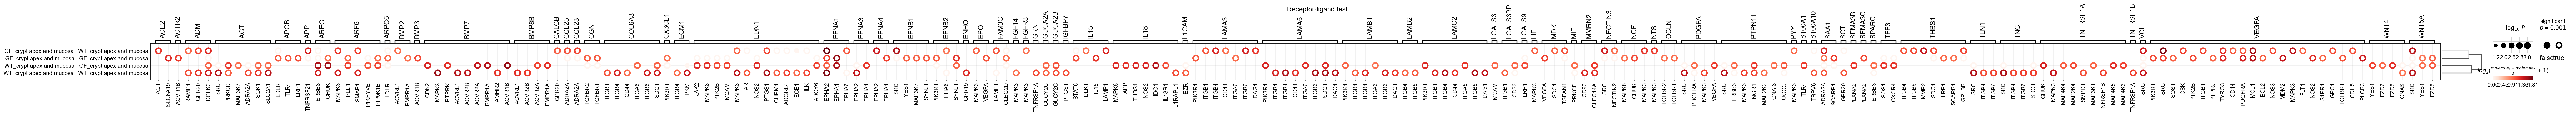

In [13]:
sq.pl.ligrec(res, source_groups=["WT_crypt apex and mucosa", "GF_crypt apex and mucosa",], 
             target_groups=["WT_crypt apex and mucosa", "GF_crypt apex and mucosa"], dendrogram = 'interacting_clusters', 
             pvalue_threshold = 0.01, means_range = [np.quantile(res['means'], 0.9), np.inf], alpha=0.001, remove_nonsig_interactions=True, cmap = 'Reds')



In [14]:
st_splotch_pd.uns['RL_inter_annotation'] = res

In [15]:
np.quantile(res['means'], 0.9)

0.8091657102108009

In [16]:
filter_rank_ligrec_st(st_splotch_pd, key = 'RL_inter_annotation', key_added = 'RL_inter_annotation_filtered', pvalue_threshold = 0.01, scores_threshold = np.quantile(res['means'], 0.9))

In [17]:
sort_rank_ligrec(st_splotch_pd, key = 'RL_inter_annotation_filtered', key_added = 'RL_inter_annotation_sorted')

MultiIndex([(            'GF_crypt apex and crypt mid', ...),
            (               'GF_crypt apex and mucosa', ...),
            (                          'GF_crypt base', ...),
            (                           'GF_crypt mid', ...),
            (                          'GF_epithelium', ...),
            (              'GF_epithelium and mucosae', ...),
            ('GF_epithelium and mucosae and submucosa', ...),
            ( 'GF_epithelium and muscle and submucosa', ...),
            (                             'GF_externa', ...),
            (                 'GF_externa and interna', ...),
            (                             'GF_interna', ...),
            (                 'GF_mucosae and interna', ...),
            (                'GF_muscle and submucosa', ...),
            (                       'GF_peyer's patch', ...),
            (            'WT_crypt apex and crypt mid', ...),
            (               'WT_crypt apex and mucosa', ...),
        

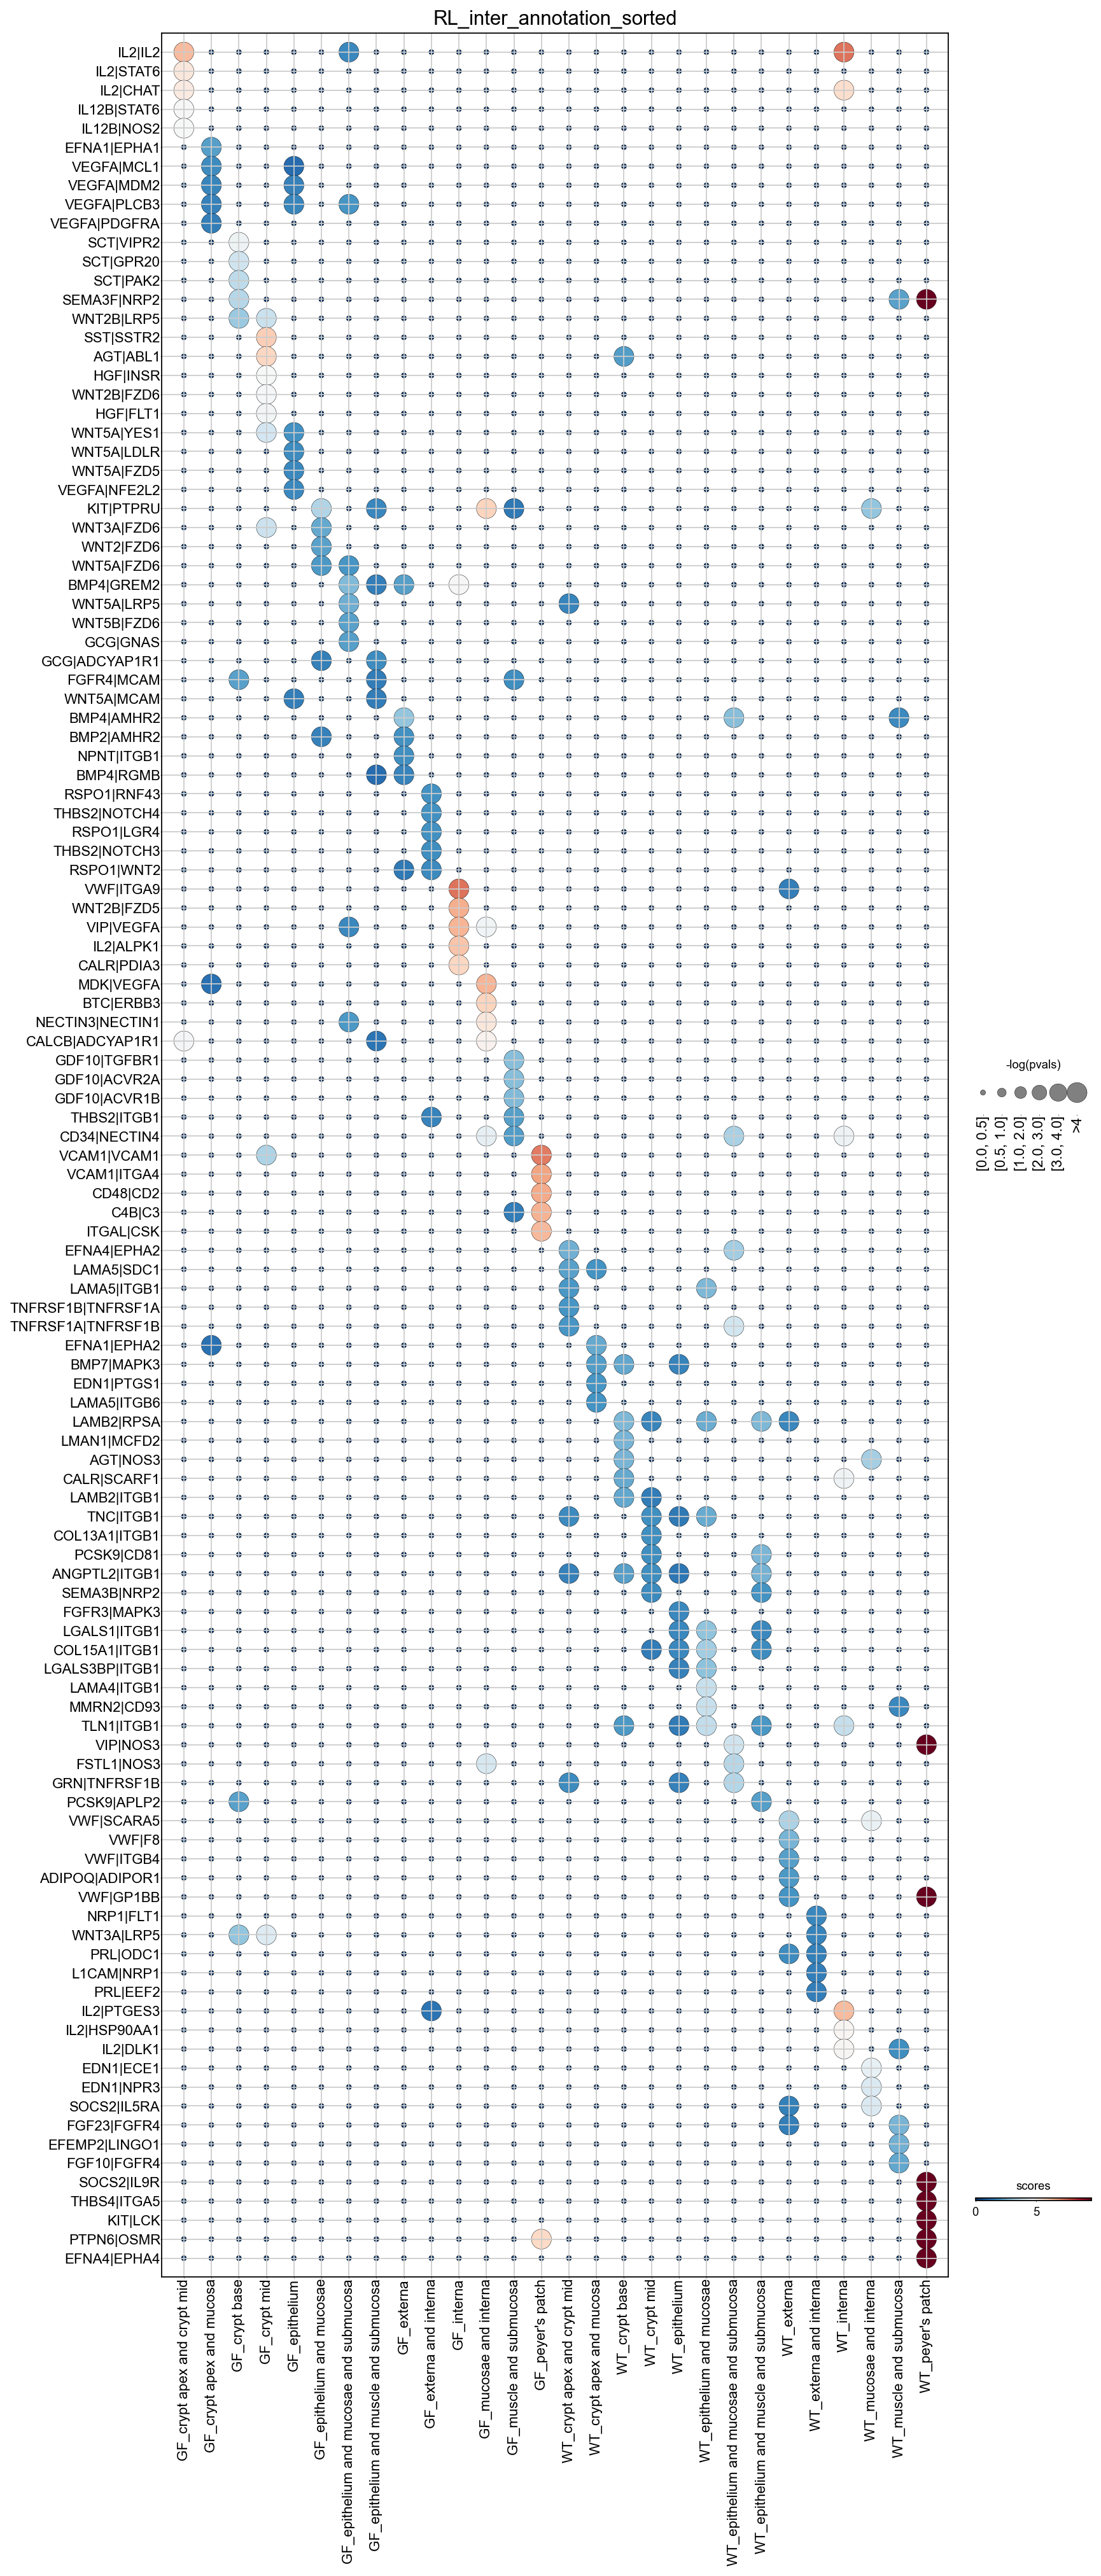

In [18]:
plot_ligrec_scores_dotplot(st_splotch_pd, n_genes = 5, 
                           key = 'RL_inter_annotation_sorted',)

In [19]:
### Repeat with only 4mrois for simplicity

In [20]:
'Save new spatial anndata'
st_splotch_pd_4mrois = st_splotch_pd[st_splotch_pd.obs.annotation.isin(['crypt apex and mucosa',
                                                                'crypt apex and crypt mid',
                                                                'crypt mid',
                                                                'crypt base'])]



### Receptor-ligand interaction using cellphoneDB

In [21]:
res = sq.gr.ligrec(
    st_splotch_pd_4mrois,
    n_perms=1000,
    cluster_key="pheno",
    copy=True,
    use_raw=False,
    transmitter_params={"categories": "ligand"},
    receiver_params={"categories": "receptor"},
)


  0%|          | 0/1000 [00:00<?, ?permutation/s]

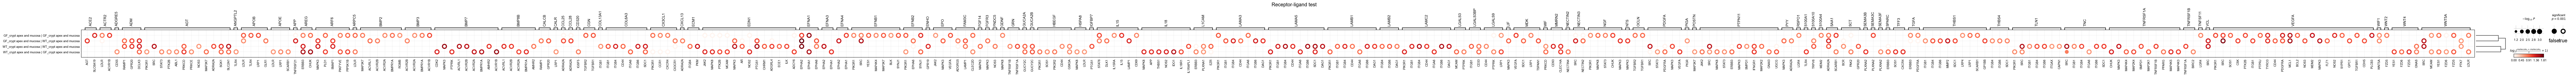

In [22]:
sq.pl.ligrec(res, source_groups=["WT_crypt apex and mucosa", "GF_crypt apex and mucosa",], 
             target_groups=["WT_crypt apex and mucosa", "GF_crypt apex and mucosa"], dendrogram = 'interacting_clusters', 
             pvalue_threshold = 0.01, means_range = [np.quantile(res['means'], 0.9), np.inf], alpha=0.001, remove_nonsig_interactions=True, cmap = 'Reds')



In [23]:
st_splotch_pd_4mrois.uns['RL_inter_annotation'] = res

In [24]:
np.quantile(res['means'], 0.9)

0.5548542916774751

In [25]:
filter_rank_ligrec_st(st_splotch_pd_4mrois, key = 'RL_inter_annotation', key_added = 'RL_inter_annotation_filtered', pvalue_threshold = 0.01, scores_threshold = np.quantile(res['means'], 0.9))

In [26]:
sort_rank_ligrec(st_splotch_pd_4mrois, key = 'RL_inter_annotation_filtered', key_added = 'RL_inter_annotation_sorted')

MultiIndex([('GF_crypt apex and crypt mid', 'GF_crypt apex and crypt mid'),
            (   'GF_crypt apex and mucosa',    'GF_crypt apex and mucosa'),
            (              'GF_crypt base',               'GF_crypt base'),
            (               'GF_crypt mid',                'GF_crypt mid'),
            ('WT_crypt apex and crypt mid', 'WT_crypt apex and crypt mid'),
            (   'WT_crypt apex and mucosa',    'WT_crypt apex and mucosa'),
            (              'WT_crypt base',               'WT_crypt base'),
            (               'WT_crypt mid',                'WT_crypt mid')],
           names=['source_groups', 'target_groups'])

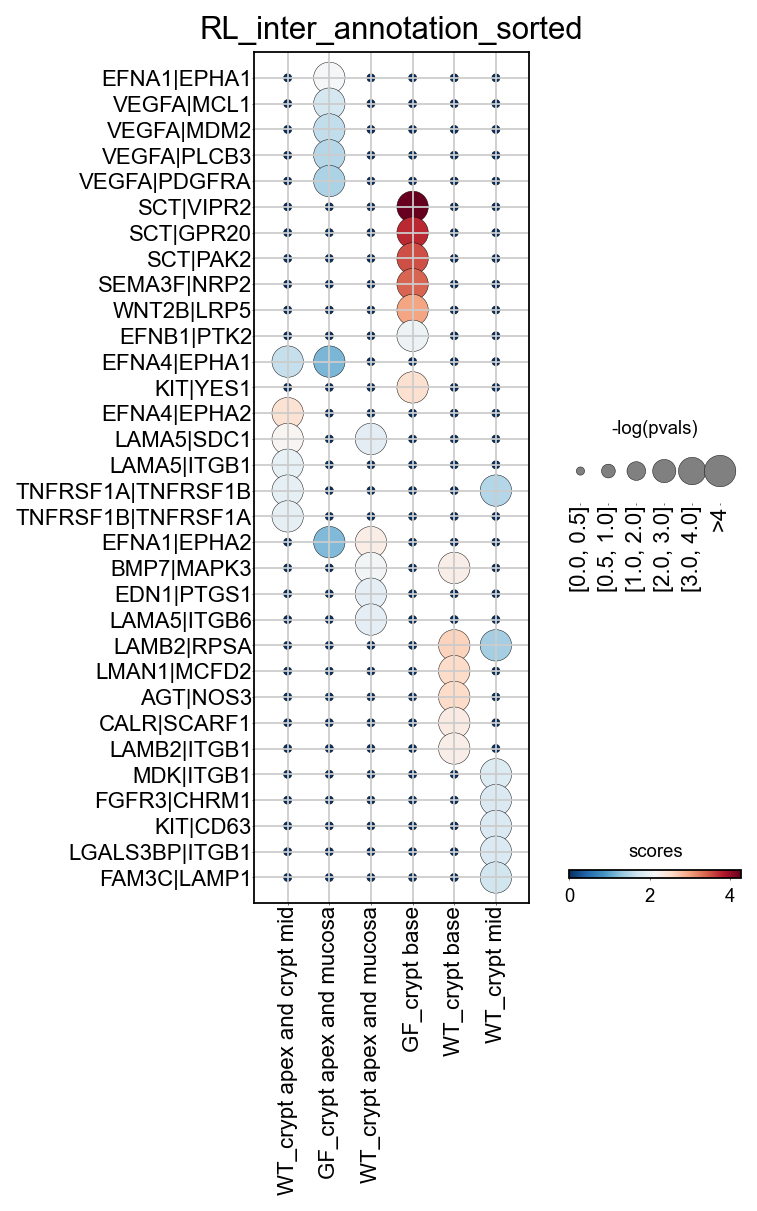

In [33]:
plot_ligrec_scores_dotplot(st_splotch_pd_4mrois, n_genes = 5, 
                           key = 'RL_inter_annotation_sorted', dot_min = 0, 
                            categories_order = 
                             ['WT_crypt apex and crypt mid', 
                              'GF_crypt apex and mucosa', 'WT_crypt apex and mucosa',
                              'GF_crypt base', 'WT_crypt base',
                              'WT_crypt mid',
                              
                             ],
                            ) #'GF_crypt mid','GF_crypt apex and crypt mid',

In [154]:
res['pvalues']

cluster_1       GF_crypt apex and crypt mid                           \
cluster_2       GF_crypt apex and crypt mid GF_crypt apex and mucosa   
source   target                                                        
FYN      JAK2                           NaN                      NaN   
KIT      JAK2                          0.05                      0.0   
EPO      JAK2                           NaN                      NaN   
NRG1     JAK2                          0.00                      0.0   
GHR      JAK2                           NaN                      NaN   
...                                     ...                      ...   
SERPINF1 PLXDC2                         NaN                      NaN   
FSTL5    SDK2                           NaN                      NaN   
HAPLN1   TREML2                         NaN                      NaN   
SPARC    PDGFC                          NaN                      NaN   
CD320    IGSF5                          NaN                      0.0   

cluster_1                                                               \
cluster_2       GF_crypt base GF_crypt mid WT_crypt apex and crypt mid   
source   target                                                          
FYN      JAK2             NaN          NaN                         NaN   
KIT      JAK2           0.005          NaN                         NaN   
EPO      JAK2             NaN          NaN                         NaN   
NRG1     JAK2           0.000          NaN                         NaN   
GHR      JAK2             NaN          NaN                         NaN   
...                       ...          ...                         ...   
SERPINF1 PLXDC2           NaN          NaN                         NaN   
FSTL5    SDK2             NaN          NaN                         NaN   
HAPLN1   TREML2           NaN          NaN                         NaN   
SPARC    PDGFC            NaN          NaN                         NaN   
CD320    IGSF5          0.000          NaN                         NaN   

cluster_1                                                            \
cluster_2       WT_crypt apex and mucosa WT_crypt base WT_crypt mid   
source   target                                                       
FYN      JAK2                        NaN           NaN          NaN   
KIT      JAK2                        NaN           NaN          NaN   
EPO      JAK2                        NaN           NaN          NaN   
NRG1     JAK2                        NaN           NaN          NaN   
GHR      JAK2                        NaN           NaN          NaN   
...                                  ...           ...          ...   
SERPINF1 PLXDC2                    0.000           0.0          NaN   
FSTL5    SDK2                        NaN           NaN          NaN   
HAPLN1   TREML2                      NaN           NaN          NaN   
SPARC    PDGFC                       NaN           NaN          NaN   
CD320    IGSF5                     0.007           NaN          NaN   

cluster_1          GF_crypt apex and mucosa                           ...  \
cluster_2       GF_crypt apex and crypt mid GF_crypt apex and mucosa  ...   
source   target                                                       ...   
FYN      JAK2                           NaN                      NaN  ...   
KIT      JAK2                           NaN                      NaN  ...   
EPO      JAK2                           0.0                      0.0  ...   
NRG1     JAK2                           NaN                      NaN  ...   
GHR      JAK2                           NaN                      NaN  ...   
...                                     ...                      ...  ...   
SERPINF1 PLXDC2                         NaN                      NaN  ...   
FSTL5    SDK2                           NaN                      NaN  ...   
HAPLN1   TREML2                         NaN                      NaN  ...   
SPARC    PDGFC                     